# Slider Experiment

In [656]:
import csv
import glob
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import scikit_posthocs as ph
import scipy.stats as stats
import seaborn as sns
import numpy as np

from collections import OrderedDict
from tabulate import tabulate

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

# Log parsing code

In [657]:
SHAPE_MOVE_THRESHOLD = 25

class Log:
    def __init__(self, PID, gesture, task, target, block, startTime, endTime, frames=None):
        self.PID = PID
        self.gesture = gesture
        self.task = task
        self.target = target
        self.block = block
        self.startTime = startTime
        self.endTime = endTime
        if frames is None:
            self.frames = []
        else:
            self.frames = frames

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

class Frame:
    def __init__(self, activity, state, cursor_X, cursor_y, slider_position_X, slider_value, message=""):
        self.activity = activity
        self.state = state
        self.cursor_X = cursor_X
        self.cursor_y = cursor_y
        self.slider_position_X = slider_position_X
        self.slider_value = slider_value
        self.message = message

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

def extract_data(jsonData):
    """
    Parse json into an instance of the Log class.
    """
    frames = []

    for f in jsonData["frames"]:
        frames.append(Frame(f["activity"], f["state"], f["cursor_X"], f["cursor_y"], f["slider_position_X"], f["slider_value"], f["message"] if "message" in f else ""))

    return Log(jsonData["PID"], jsonData["gesture"], jsonData["task"], jsonData["target"], jsonData["block"], jsonData["startTime"], jsonData["endTime"], frames)

def block_success(data: Log):
    """
    Determine task success based on the final slider value.
    """
    frame = data.frames[-1]
    
    return ((frame.slider_value == data.target) or (data.task == "shapeMove" and abs(frame.slider_value - data.target) <= SHAPE_MOVE_THRESHOLD))

def last_hand_time(data: Log):
    """
    Calculates the time where a hand was last recognised by the Leap Motion sensor.
    """
    
    # Total number of frames
    total_frames = len(data.frames)
    
    # Running count of frames
    frame_count = 0
    
    # Task start frame
    task_start_frame = -1
    
    # Running count of task number - needed since frames contains all previous tasks
    current_block_num = 0
    
    # Log start and end time
    log_start_time = data.startTime
    log_end_time   = data.endTime
    
    # Loop from start to get the proper subset of frames
    for frame in data.frames:
        frame_count += 1
        
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Initialise the frame index where this task started
        if task_start_frame == -1:
            task_start_frame = frame_count
            total_frames -= frame_count
            frame_count = 0
            break
    
    # Loop from end
    for i in range(len(data.frames) - 1, task_start_frame, -1):
        frame_count += 1
        ratio = frame_count / float(total_frames)
        
        if data.frames[i].state != "NoHands":
            return ratio * (log_end_time - log_start_time)

def first_hand_time(data: Log):
    """
    Calculates the time where a hand was first recognised by the Leap Motion sensor.
    """
    
    # Total number of frames
    total_frames = len(data.frames)
    
    # Running count of frames
    frame_count = 0
    
    # Task start frame
    task_start_frame = -1
    
    # Running count of task number - needed since frames contains all previous tasks
    current_block_num = 0
    
    # Log start and end time
    log_start_time = data.startTime
    log_end_time   = data.endTime
    
    for frame in data.frames:
        frame_count += 1
        
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Initialise the frame index where this task started
        if task_start_frame == -1:
            task_start_frame = frame_count
            total_frames -= frame_count
            frame_count = 0
        
        # Calculate the ratio for the current frame index
        ratio = frame_count / float(total_frames)
        
        if frame.message == "Transitioning from states NoHands to NoPinchDetected":
            return ratio * (log_end_time - log_start_time)

def time(data: Log):
    """
    Calculate overall task time, time taken for first land on a target, and time taken to grab the slider handle.
    """
    
    # Total number of frames
    total_frames = len(data.frames)
    
    # Running count of frames
    frame_count = 0
    
    # Task start and end time
    task_start_frame = -1
    time_start = data.startTime
    time_end = data.endTime
    
    # Calculate task time using the log data as a fallback...
    time = time_end - time_start
    
    # Time where the user first hits the target
    time_hit = -1
    time_hit_calculated = False
    
    # Time where the user first grabs the handle
    time_grabbed = -1
    time_grabbed_calculated = False
    
    # Running count of task number - needed since frames contains all previous tasks
    current_block_num = 0
    
    for frame in data.frames:
        frame_count += 1
        
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Initialise the frame index where this task started
        if task_start_frame == -1:
            task_start_frame = frame_count
            total_frames -= frame_count
            frame_count = 0
        
        # Calculate the ratio for the current frame index
        ratio = frame_count / float(total_frames)
        
        # Check if the user has grabbed the slider handle for the first time
        if not time_grabbed_calculated and ((frame.message in ["Gesture detected on slider"]) or (data.gesture == "pinchAny" and frame.message == "Transitioning from states NoPinchDetected to PinchDetected")):
            time_grabbed_calculated = True
            time_grabbed = ratio * (time_end - time_start)
        
        # Check if the slider has hit the target for the first time
        if (frame.slider_value == data.target) or (data.task == "shapeMove" and abs(frame.slider_value - data.target) <= SHAPE_MOVE_THRESHOLD):
            time_hit = ratio * (time_end - time_start)    
            time_hit_calculated = True
        
        if time_hit_calculated:
            break

    return (time, time_hit, time_grabbed)

def overshoots(data: Log):
    """
    Count the number of target overshoots. There are two types of overshoot: going above and
    going below the target value. These are counted when the selected slider value moves over
    the target in a sequence. Might be some bugs with this, e.g., if the slider never perfectly
    sets on the target.
    """
    overList = []
    overCount = 0
    
    # Has crossed to a higher value
    crossed_above = False
    
    # Has crossed to a lower value
    crossed_below = False
    
    current_block_num = 0
    
    for frame in data.frames:
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Now we can start counting
        if frame.slider_value > data.target:
            if not crossed_above:
                crossed_above = True
                crossed_below = False
                
                overCount += 1
                
            overList.append(frame.slider_value)
        else:
            crossed_above = False
            
            if frame.slider_value == data.target:
                crossed_below = True # Not true, but we need to know when we fall off the other side
            else:
                if crossed_below:
                    crossed_below = False
                    
                    overCount += 1
                
                overList.append(frame.slider_value)
            
    return (overList, overCount)

def alphabet_target(letter):
    """
    Calculates the target coordinate for the given letter.
    """
    letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
    target_width = 52.30769230769231
    target_offset = letters.index(letter)
    
    return 600.0 + (target_width / 2.0) + (target_width * target_offset)

def digit_target(digit):
    """
    Calculates the target coordinator for the given digit.
    """
    target_width = 136.0
    
    return 600.0 + (target_width / 2.0) + (target_width * digit)

def target_distance(data: Log):
    """
    Calculates the distance in pixels between the target and the final cursor position.
    """
    if len(data.frames) == 0:
        return None
    
    frame = data.frames[-1]
    
    if data.task == "shapeMove":
        return frame.slider_value - data.target
    elif data.task == "alphaSelector":
        return frame.slider_position_X - alphabet_target(data.target)
    elif data.task == "digitSelector":
        return frame.slider_position_X - digit_target(data.target)
    else:
        return None

def target_distance_ratio(data: Log):
    """
    Calculates the ratio of target distance to target pixel.
    """
    if len(data.frames) == 0:
        return None
    
    frame = data.frames[-1]
    
    if data.task == "shapeMove":
        return frame.slider_value / data.target
    elif data.task == "alphaSelector":
        return frame.slider_position_X / alphabet_target(data.target)
    elif data.task == "digitSelector":
        return frame.slider_position_X / digit_target(data.target)
    else:
        return None

def count_engagements(data: Log):
    """
    Calculates the number of times the user 'engaged' the slider.
    """
    engaged = False
    count = 0
    
    current_block_num = 0
    
    for frame in data.frames:
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Now we can start counting
        if frame.message in ["Transitioning from states NoPinchDetected to PinchDetected", "Transitioning from states NoDwellDetected to DwellDetected"]:
            count += 1
    
    return count

def slider_loc(data: Log):
    """
    Returns the final slider coordinate.
    """
    return ((data.frames[-1].slider_position_X))

# Import log data

In [658]:
columnNames = ["P", "B", "Condition", "Task", "Target", "Selected", "Time", "Time to Target", "Time Grabbed", "Success",
               "Activations", "Overshoots", "Overshoot_Values", "Location", "ErrorDistance", "AbsErrorDistance", "ErrorDistanceRatio",
               "FirstHandTime", "LastHandTime"]
data = pd.DataFrame(columns = columnNames)

files = glob.glob("../Logs/*/*/*/*.json")
log: Log

# Log files for individual participants can be cached to save regenerating everything
cache_logs = glob.glob("Cache/*.tsv")
use_cache = True

if True:
    for file in files:
        with open(file) as json_file:
            pid = file.split("/")[-4]
            condition = file.split("/")[-2]
            task = file.split("/")[-3]
            
            if use_cache and "Cache/P{}.tsv".format(pid,) in cache_logs:
                continue

            if pid not in ["-1", "1", "2", "3", "4"]:
                log = extract_data(json.load(json_file))

                first_hand = first_hand_time(log)
                last_hand = last_hand_time(log)
                (task_time, time_to_hit, time_grabbed) = time(log)
                success = block_success(log)
                (overshootHits, overshootCount) = overshoots(log)
                activations = count_engagements(log)
                sliderPos = slider_loc(log)
                errorDistance = target_distance(log)
                errorDistanceRatio = target_distance_ratio(log)

                log_data = pd.DataFrame(columns = columnNames, data =
                                        [[pid, log.block, condition, task, log.target, log.frames[-1].slider_value,
                                          task_time, time_to_hit, time_grabbed, success, activations, overshootCount, set(overshootHits),
                                          sliderPos, errorDistance, abs(errorDistance), errorDistanceRatio, first_hand, last_hand]])
                
                # Add into main data frame
                data = pd.concat([data, log_data], ignore_index=True)
    
    # Now read in the cached results
    if use_cache:
        for file in cache_logs:
            data_cached = pd.read_csv(file, sep="\t")
            data = pd.concat([data, data_cached], ignore_index=True)
    
    # Drop task time outliers
    data_filtered = data[data['Time'] <= 30000]
    data_filtered = data_filtered[data_filtered['Time to Target'] <= 10000]
    data_filtered = data_filtered[data_filtered['Time'] > 10]
    data_filtered = data_filtered[data_filtered['FirstHandTime'] < 3000]
    data_filtered = data_filtered[data_filtered['LastHandTime'] < 500]
    
    # Drop tasks where the target was the first cursor point
    data_filtered = data_filtered[data_filtered['Target'] != "A"]
    data_filtered = data_filtered[data_filtered['Target'] != 1]
    
    # Drop tasks with distance outliers
    data_filtered = data_filtered[data_filtered['AbsErrorDistance'] <= 150]

    n_new = len(data)
    n_new_filtered = len(data_filtered) 
    print("Read {} new results and kept {} after filtering".format(n_new, n_new_filtered,))
    
    # Write all data to a single file
    data_filtered.to_csv("all_data.tsv", sep="\t")
else:
    data_filtered = pd.read_csv("all_data.tsv", sep="\t")
    
    print("Read {} results".format(len(data_filtered)))
    
# Write individual participant data
for p in data_filtered.P.unique():
    df_p = data_filtered[data_filtered.P == p]
    df_p.to_csv("Cache/P{}.tsv".format(p,), sep="\t")

# Force category types and re-order labels
data_filtered["Condition"] = data_filtered["Condition"].astype('category')
data_filtered["Task"] = data_filtered["Task"].astype('category')
data_filtered["Condition"] = data_filtered["Condition"].cat.reorder_categories(["baseline", "Dwell", "pinchOnCircle", "pinchAny"])
data_filtered["Task"] = data_filtered["Task"].cat.reorder_categories(["alphaSelector", "digitSelector", "shapeMove"])

# Force metrics to numeric type
data_filtered["Time"] = pd.to_numeric(data_filtered["Time"])
data_filtered["Time to Target"] = pd.to_numeric(data_filtered["Time to Target"])
data_filtered["Time Grabbed"] = pd.to_numeric(data_filtered["Time Grabbed"])
data_filtered["ErrorDistance"] = pd.to_numeric(data_filtered["ErrorDistance"])
data_filtered["AbsErrorDistance"] = pd.to_numeric(data_filtered["AbsErrorDistance"])
data_filtered["ErrorDistanceRatio"] = pd.to_numeric(data_filtered["ErrorDistanceRatio"])
data_filtered["Success"] = pd.to_numeric(data_filtered["Success"])
data_filtered["Overshoots"] = pd.to_numeric(data_filtered["Overshoots"])
data_filtered["Activations"] = pd.to_numeric(data_filtered["Activations"])
data_filtered["FirstHandTime"] = pd.to_numeric(data_filtered["FirstHandTime"])
data_filtered["LastHandTime"] = pd.to_numeric(data_filtered["LastHandTime"])

# Calculate aggregate values across repeated measures
data_agg = data_filtered.groupby(["P", "Condition", "Task"], as_index=False)[["Time", "Time to Target", "Time Grabbed", "ErrorDistance", "AbsErrorDistance",
                                                                              "ErrorDistanceRatio", "Success", "Overshoots", "Activations", "FirstHandTime", "LastHandTime"]].mean()


Read 1512 new results and kept 1512 after filtering


# Summary

In [662]:
print("Read data from {} participants".format(len(data_filtered.P.unique()),))

data_agg.agg({'Time': ['mean', 'std', 'min', 'max', 'count'],
                   'Time to Target': ['mean', 'std', 'min', 'max'],
                   'Time Grabbed': ['mean', 'std', 'min', 'max'],
                   'Success': ['mean', 'std', 'min', 'max'],
                   'Overshoots': ['mean', 'std', 'min', 'max'],
                   'Activations': ['mean', 'std', 'min', 'max'],
                   'ErrorDistance': ['mean', 'std', 'min', 'max'],
                   'AbsErrorDistance': ['mean', 'std', 'min', 'max'],
                   'ErrorDistanceRatio': ['mean', 'std', 'min', 'max'],
                   'FirstHandTime': ['mean', 'std', 'min', 'max'],
                   'LastHandTime': ['mean', 'std', 'min', 'max'],
             })

Read data from 15 participants


,Time,Time to Target,Time Grabbed,Success,Overshoots,Activations,ErrorDistance,AbsErrorDistance,ErrorDistanceRatio,FirstHandTime,LastHandTime
mean,9187.831159,4659.163053,1815.707856,0.964594,1.050558,3.080785,1.193472,10.278893,1.001253,302.502209,135.149707
std,3619.864430,1487.829955,793.229118,0.089945,0.886007,1.465689,7.477369,6.491398,0.006210,268.120975,120.845319
min,2465.272727,1390.333044,-1.000000,0.444444,0.000000,1.000000,-25.947775,2.351319,0.983875,8.814455,8.082914
max,23798.000000,9365.905734,4290.369992,1.000000,6.000000,10.000000,44.559300,44.559300,1.041288,2200.459641,476.905694
count,177.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [663]:
t2 = data_filtered[data_filtered["Task"] == "digitSelector"]
t2 = t2[t2['Success'] == True]
#print(t2[['Condition', 'Time', 'Target']])
#print(t2)
t2a = t2.groupby('B')['Time'].mean().reset_index()
print(t2a)

#point_plot(t2, "Time", "B", 12, (0, 12000), "Time (ms)", plot_w=7, plot_h=2)

     B         Time
0    0  9204.461538
1    1  7733.589744
2    2  7444.710526
3    3  7965.972222
4    4  8032.685714
5    5  7534.600000
6    6  7214.434783
7    7  7648.311111
8    8  7065.880952
9    9  7683.295455
10  10  6975.973684
11  11  6637.930233


# Exploratory plots

In [664]:
def point_plot(df, dv, iv, n_iv, xlim=(0, 1), xlab="", ylab="", show_grid=False, show_all=True, v_annotate=None, plot_w=7, plot_h=2, filename=None):
    """
    Creates a point plot showing mean values with 95% confidence intervals.
    
    df: Data frame.
    dv: Column name with the dependent variable measurements.
    iv: Column name with the independent variable values.
    n_iv: Number of levels in the independent variable.
    max_x: Maximum x-axis value.
    show_grid: If True, show a grid in the plot.
    show_all: If True, include a strip plot.
    v_annotate: Specifies optional location of vertical line annotation.
    plot_w: Plot width in inches.
    plot_h: Plot height in inches.
    filename: If given, save to a pdf with this filename.
    """
    plot, axis = plt.subplots(figsize=(plot_w, plot_h))
    
    if v_annotate is not None:
        plt.axvline(v_annotate, 0, 1, dashes=[3, 3], alpha=0.5, color="grey")
    
    if show_all:
        sns.stripplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=True, size=6, alpha=0.05, jitter=1.05)
        sns.pointplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)
    else:
        sns.pointplot(x=dv, y=iv, hue=iv, data=df, palette=palette, join=False, errwidth=1.2, scale=1.5, ci=95)

    # Adjust legend
    handles, labels = axis.get_legend_handles_labels()
    
    for i, label in enumerate(labels):
        if label == "pinchAny":
            labels[i] = "Pinch Anywhere"
        elif label == "pinchOnCircle":
            labels[i] = "Pinch"
        elif label == "baseline":
            labels[i] = "Air Push"
        elif label == "alphaSelector":
            labels[i] = "Letters"
        elif label == "digitSelector":
            labels[i] = "Digits"
        elif label == "shapeMove":
            labels[i] = "Scale"
    
    axis.legend(handles[0:n_iv], labels[0:n_iv], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

    # Adjust axes
    axis.set_ylabel(ylab)
    axis.set_xlabel(xlab)
    axis.set(xlim=xlim)
    axis.yaxis.set_visible(False)
    axis.grid(show_grid)
    
    if show_all:
        axis.margins(x=0.05, y=0.05)

    # Show and save
    plt.show()
    
    if filename is not None:
        plot.savefig(filename, bbox_inches='tight')
        
    return (plot, axis)
        
def point_plot_2f(df, dv, iv1, iv2, n_iv1, n_iv2, xlim=(0, 1), xlab="", ylab="", v_annotate=None, show_grid=False, show_all=True, plot_w=7, plot_h=5, filename=None):
    """
    Creates a two-factor point plot showing mean values with 95% confidence intervals.
    
    df: Data frame.
    dv: Column name with the dependent variable measurements.
    iv1: Column name with the first independent variable values.
    iv2: Column name with the second independent variable values.
    n_iv1: Number of levels in the first independent variable.
    n_iv2: Number of levels in the second independent variable.
    max_x: Maximum x-axis value.
    show_grid: If True, show a grid in the plot.
    show_all: If True, include a strip plot.
    plot_w: Plot width in inches.
    plot_h: Plot height in inches.
    filename: If given, save to a pdf with this filename.
    """
    
    plot, axis = plt.subplots(figsize=(plot_w, plot_h))

    if v_annotate is not None:
        plt.axvline(v_annotate, 0, 1, dashes=[3, 3], alpha=0.5, color="grey")
    
    if show_all:
        sns.stripplot(x=dv, y=iv1, hue=iv2, data=df, palette=palette, dodge=True, size=6, alpha=0.05, jitter=0.3)

    sns.pointplot(x=dv, y=iv1, hue=iv2, data=df, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

    # Adjust legend
    handles, labels = axis.get_legend_handles_labels()
    
    for i, label in enumerate(labels):
        if label == "pinchAny":
            labels[i] = "Pinch Anywhere"
        elif label == "pinchOnCircle":
            labels[i] = "Pinch"
        elif label == "baseline":
            labels[i] = "Air Push"
        elif label == "alphaSelector":
            labels[i] = "Letters"
        elif label == "digitSelector":
            labels[i] = "Digits"
        elif label == "shapeMove":
            labels[i] = "Scale"
    
    axis.legend(handles[0:n_iv1], labels[0:n_iv1], handletextpad=0, columnspacing=1, loc="lower center", ncol=n_iv1, frameon=False, bbox_to_anchor=(0.493, 1.0))

    # Adjust axes
    axis.set_ylabel(ylab)
    axis.set_xlabel(xlab)
    axis.set(xlim=xlim)
    axis.yaxis.set_visible(True)
    axis.grid(show_grid)

    # Show and save
    plt.show()
    
    if filename is not None:
        plot.savefig(filename, bbox_inches='tight')
    
    return (plot, axis)

In [665]:
def confidence(dataframe, group):
    """
    Calculate mean, SD and 95% confidence intervals for the given variable.
    """
    group = dataframe[group]
    upper = group.mean() + 1.96 * (group.std()/math.sqrt(group.count()))
    lower = group.mean() - 1.96 * (group.std()/math.sqrt(group.count()))
    return "Mean: " + str(group.mean()) + ", StDev: " + str(group.std()) + ", 95% confidence: [" + str(lower) + ", " + str(upper) + "]"

## Task Time

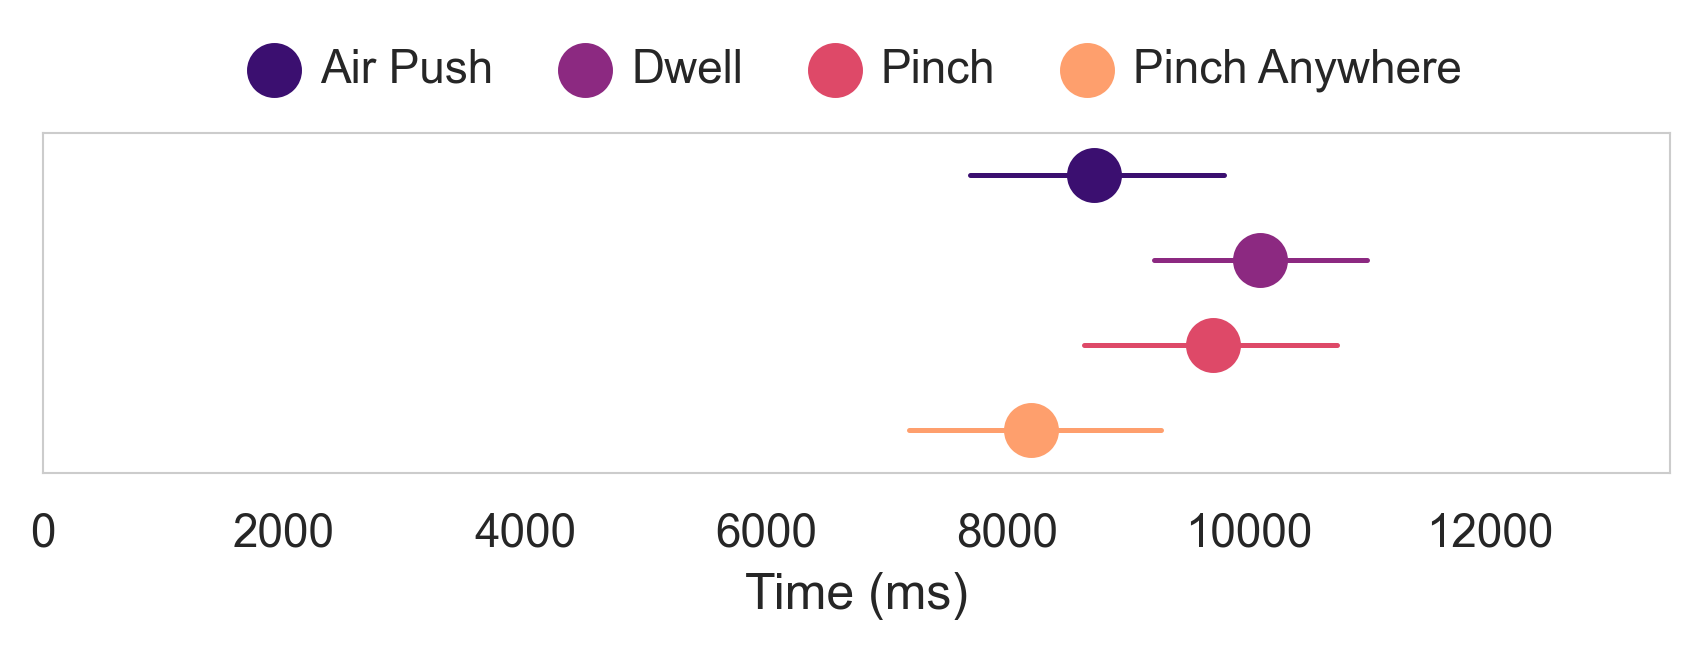

(<Figure size 2100x450 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [666]:
point_plot(data_agg, "Time", "Condition", len(data_agg.Condition.unique()), (0, 13500), "Time (ms)", plot_w=7, plot_h=1.5, show_all=False, filename="Plots/Time-Technique.pdf")

In [667]:
data_agg.groupby('Condition', as_index=False)['Time'].mean()

,Condition,Time
0,baseline,8719.006068
1,Dwell,10100.095194
2,pinchOnCircle,9704.240212
3,pinchAny,8195.348581


In [668]:
data_agg.groupby(['Condition', 'Task'], as_index=False)['Time'].mean()

,Condition,Task,Time
0,baseline,alphaSelector,7661.973098
1,baseline,digitSelector,7255.250823
2,baseline,shapeMove,11239.794283
3,Dwell,alphaSelector,9668.255707
4,Dwell,digitSelector,8861.492910
5,Dwell,shapeMove,11770.536965
6,pinchOnCircle,alphaSelector,8618.045091
7,pinchOnCircle,digitSelector,8804.982537
8,pinchOnCircle,shapeMove,11629.742496
9,pinchAny,alphaSelector,7585.388636


In [669]:
confidence(data_agg, "Time")

'Mean: 9187.831158844294, StDev: 3619.8644297069077, 95% confidence: [8654.543241626701, 9721.119076061887]'

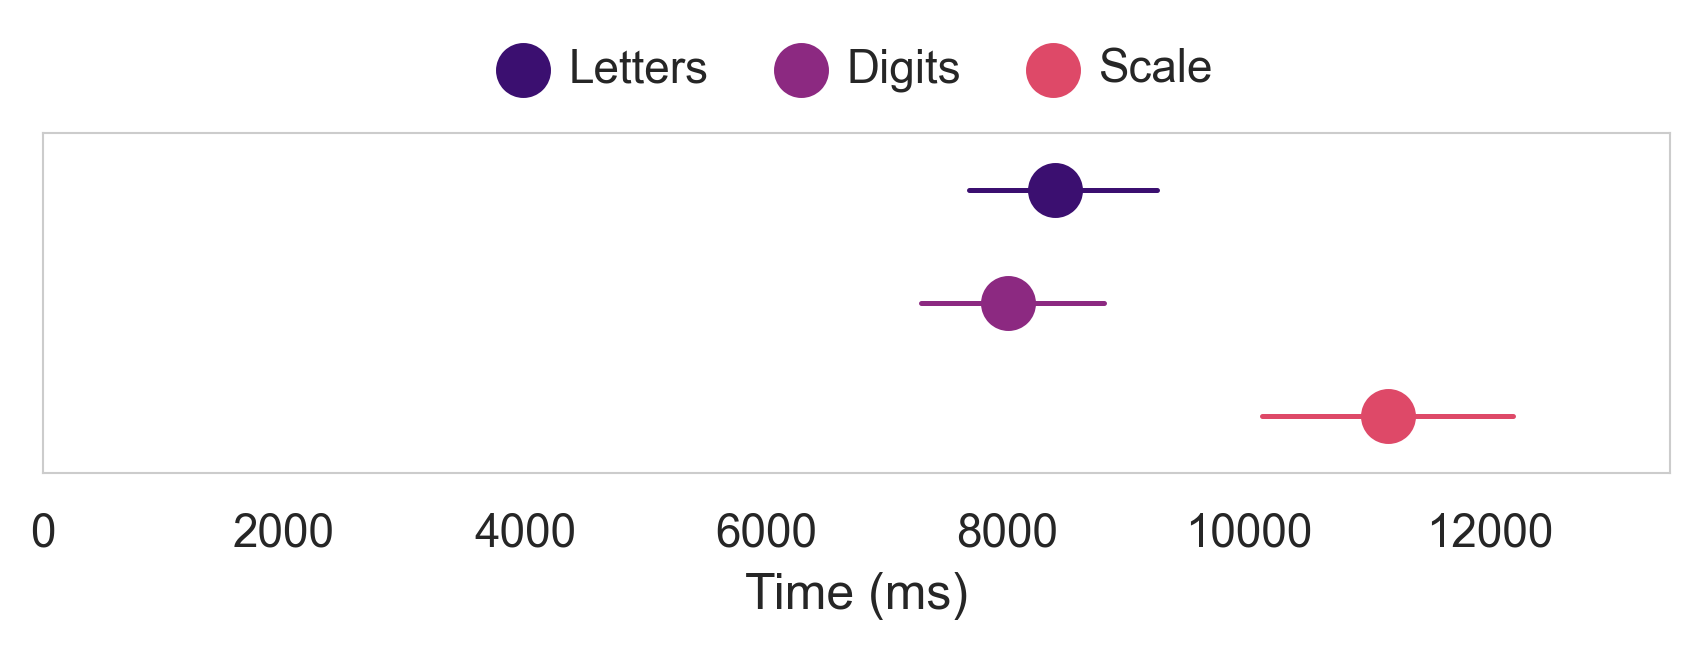

(<Figure size 2100x450 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [670]:
point_plot(data_agg, "Time", "Task", len(data_agg.Task.unique()), (0, 13500), "Time (ms)", plot_w=7, plot_h=1.5, show_all=False, filename="Plots/Time-Task.pdf")

In [671]:
data_agg.groupby('Task', as_index=False)['Time'].mean()

,Task,Time
0,alphaSelector,8396.941514
1,digitSelector,8009.340287
2,shapeMove,11157.211675


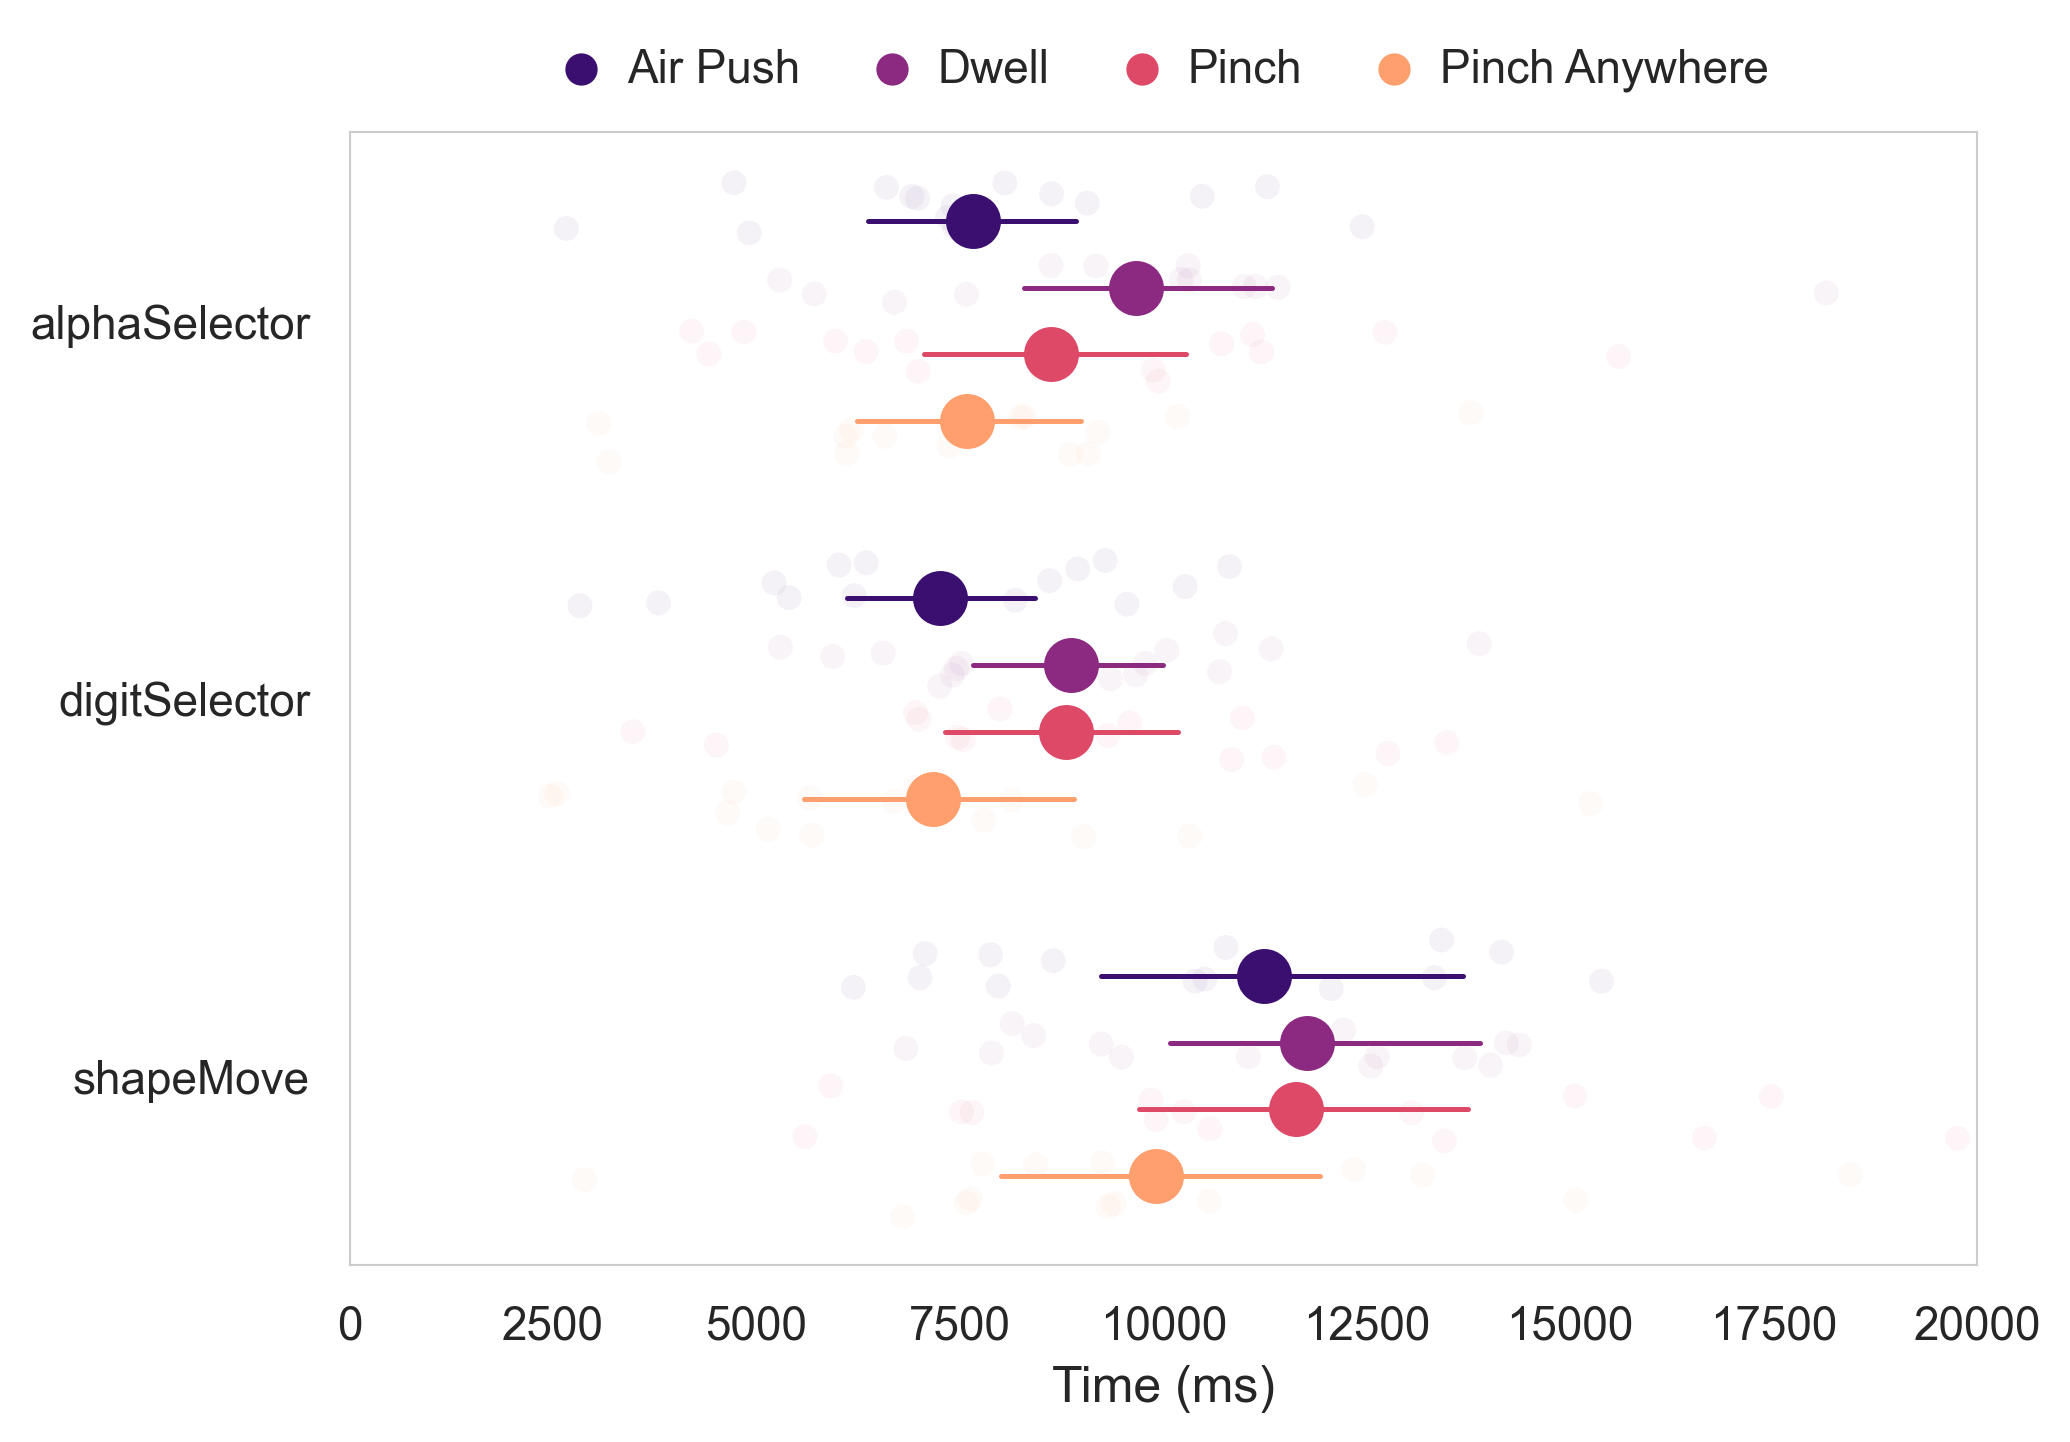

(<Figure size 2100x1500 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [672]:
point_plot_2f(data_agg, "Time", "Task", "Condition", n_iv1=len(data_agg.Condition.unique()), n_iv2=len(data_agg.Task.unique()), xlim=(0, 20000), xlab="Time (ms)", show_grid=False, filename="taskTime.pdf")

## Time to first acquire target

Excludes trials where the target was never directly hit.

In [701]:
confidence(data_agg, "Time to Target")

'Mean: 4659.163052807869, StDev: 1487.8299551940336, 95% confidence: [4439.972043479485, 4878.354062136252]'

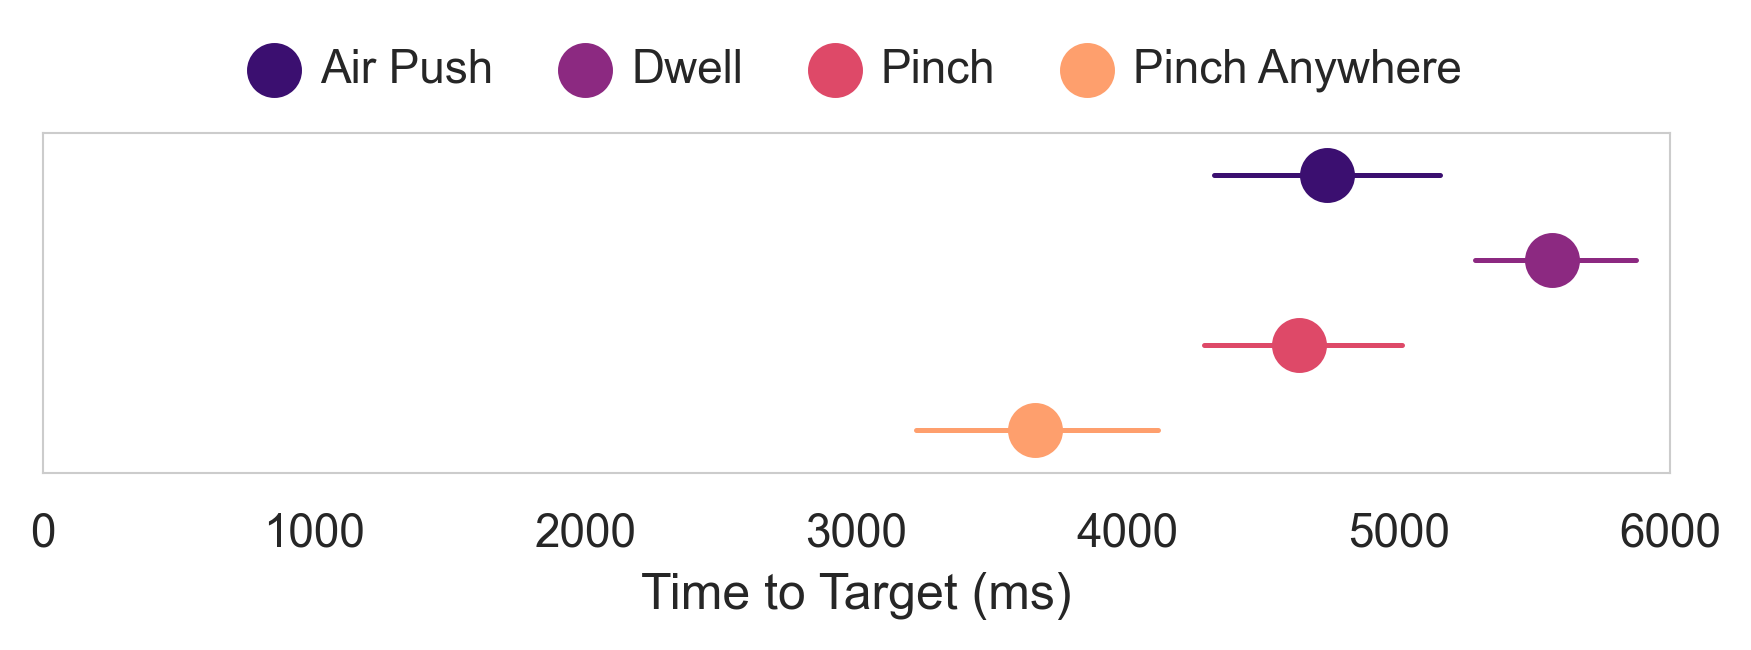

(<Figure size 2100x450 with 1 Axes>,
 <AxesSubplot:xlabel='Time to Target (ms)'>)

In [704]:
point_plot(data_agg, "Time to Target", "Condition", len(data_agg.Condition.unique()), (0, 6000), "Time to Target (ms)", plot_w=7, plot_h=1.5, show_all=False, filename="Plots/TimeToTarget-Technique.pdf")

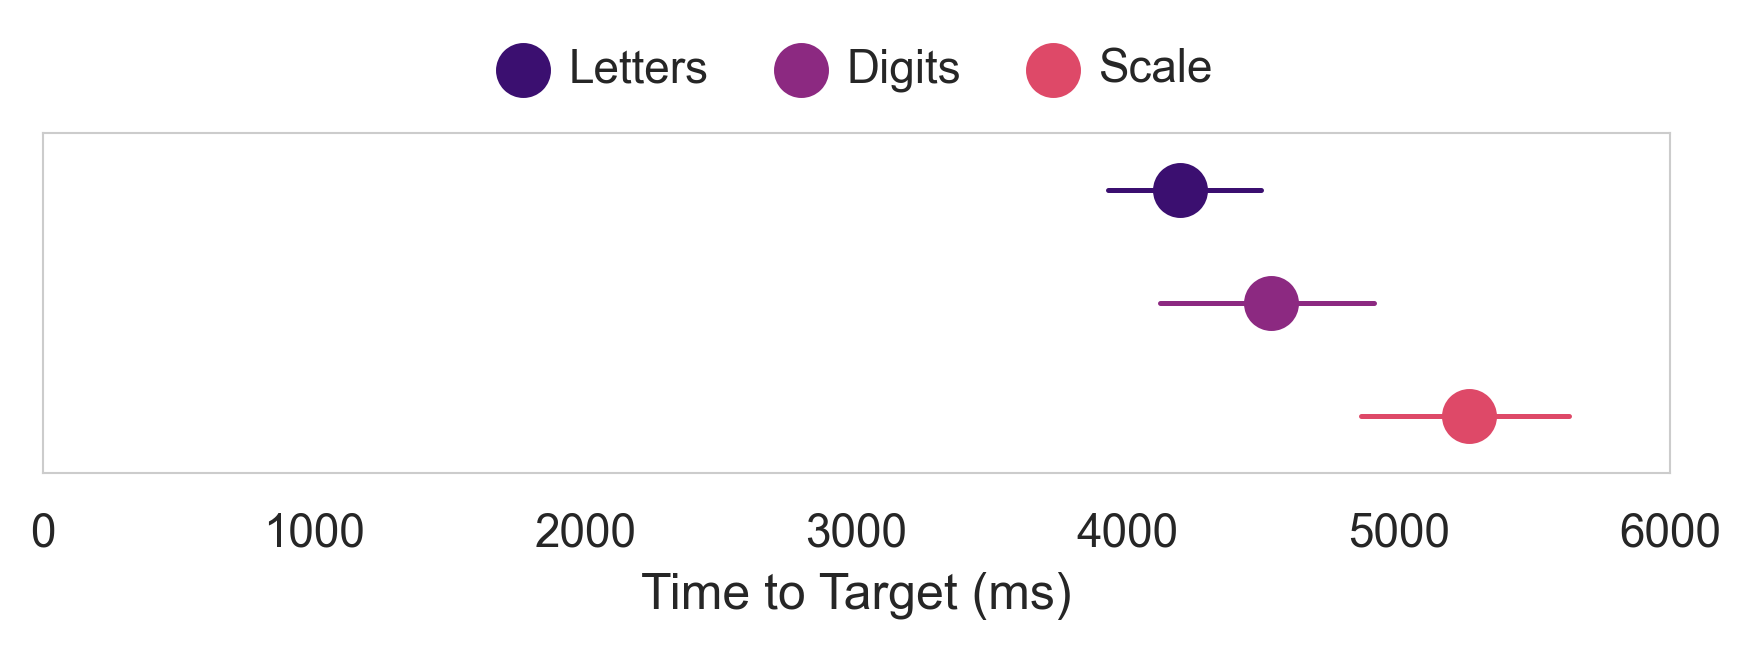

(<Figure size 2100x450 with 1 Axes>,
 <AxesSubplot:xlabel='Time to Target (ms)'>)

In [705]:
point_plot(data_agg, "Time to Target", "Task", len(data_agg.Task.unique()), (0, 6000), "Time to Target (ms)", plot_w=7, plot_h=1.5, show_all=False, filename="Plots/TimeToTarget-Task.pdf")

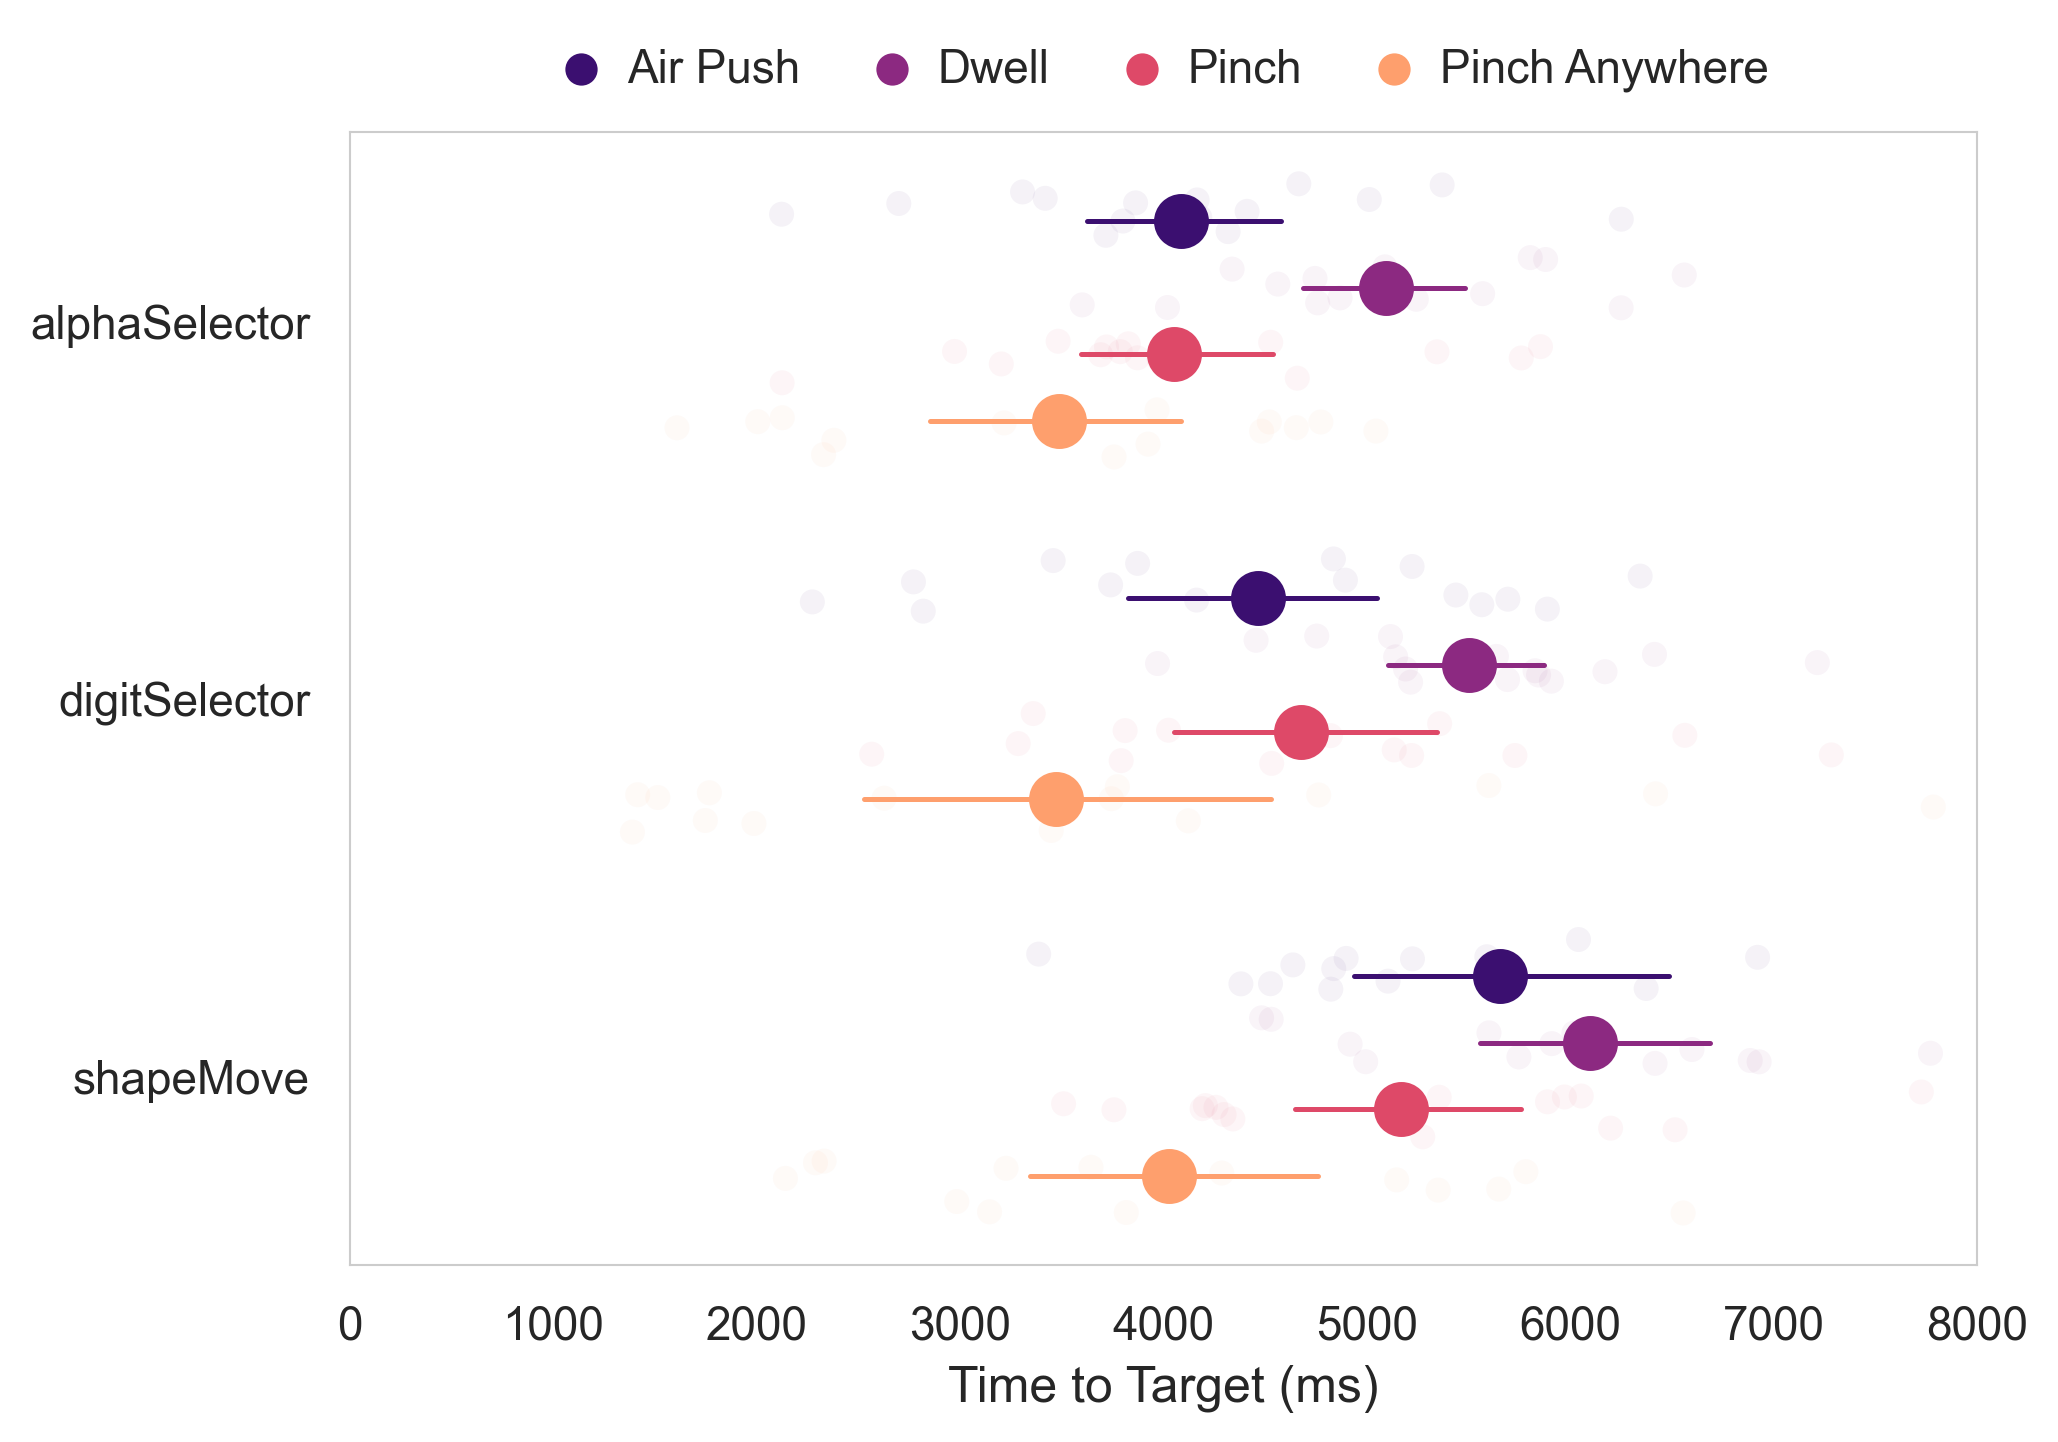

(<Figure size 2100x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Time to Target (ms)'>)

In [675]:
point_plot_2f(data_agg, "Time to Target", iv1="Task", iv2="Condition", n_iv1=len(data_agg.Condition.unique()), n_iv2=len(data_agg.Task.unique()), xlim=(0, 8000), xlab="Time to Target (ms)", plot_w=7, plot_h=5)

## Time to Grab Slider Handle

In [676]:
data_agg.groupby('Condition', as_index=False)['Time Grabbed'].mean()

,Condition,Time Grabbed
0,baseline,2286.549689
1,Dwell,2211.554661
2,pinchOnCircle,1694.022769
3,pinchAny,1033.223093


In [699]:
confidence(data_agg, "Time Grabbed")

'Mean: 1815.707856433712, StDev: 793.2291176162067, 95% confidence: [1698.8472633854396, 1932.5684494819845]'

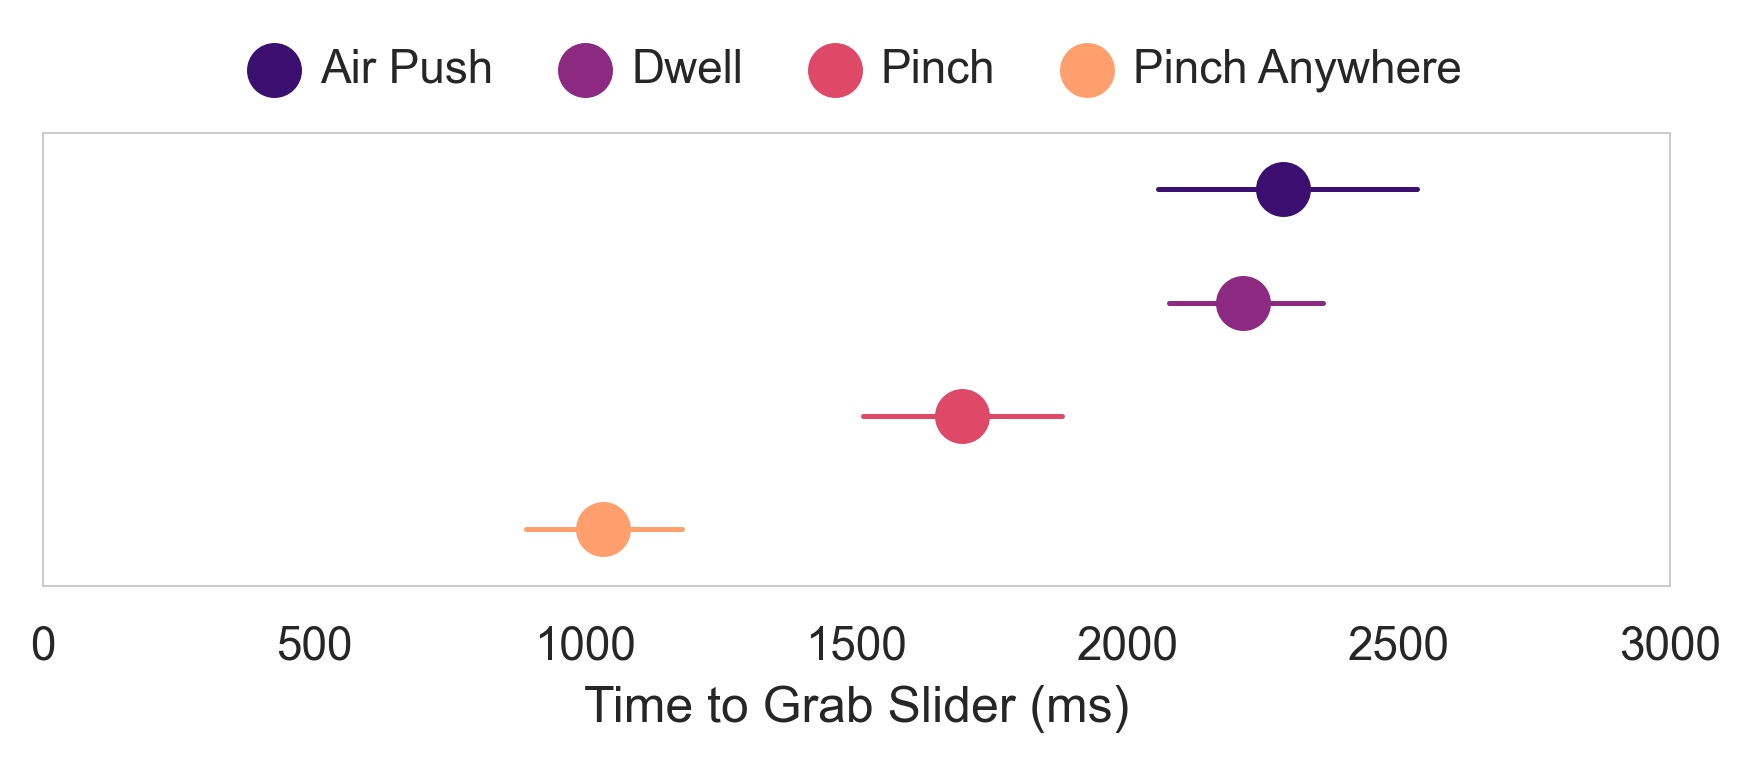

(<Figure size 2100x600 with 1 Axes>,
 <AxesSubplot:xlabel='Time to Grab Slider (ms)'>)

In [677]:
point_plot(data_agg, "Time Grabbed", "Condition", len(data_agg.Condition.unique()), (0, 3000), "Time to Grab Slider (ms)", plot_w=7, plot_h=2, show_all=False, filename="Plots/TimeGrabbed-Technique.pdf")

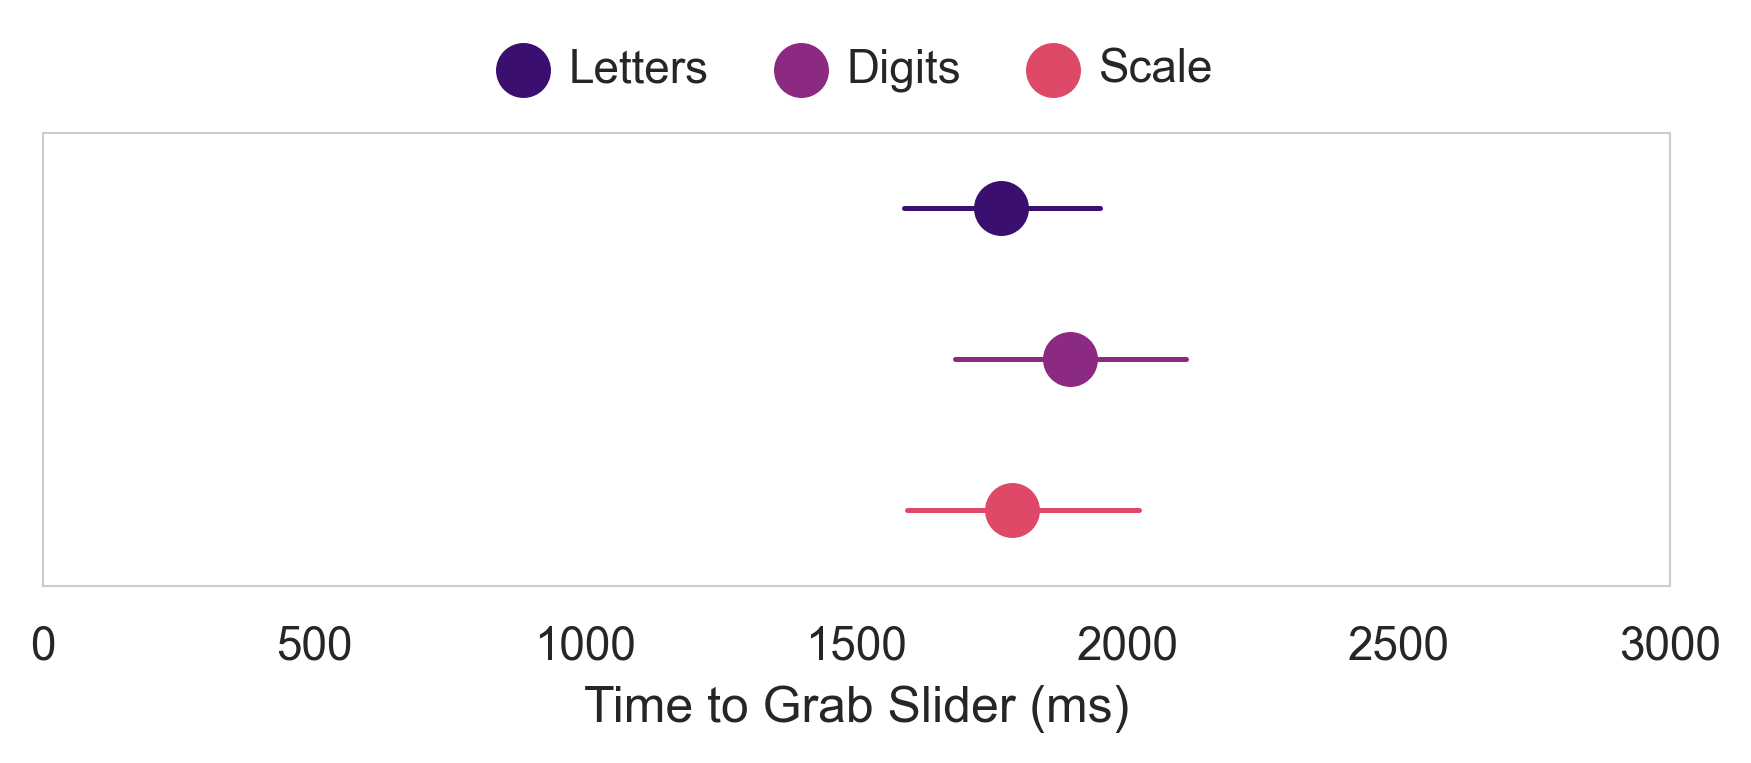

(<Figure size 2100x600 with 1 Axes>,
 <AxesSubplot:xlabel='Time to Grab Slider (ms)'>)

In [678]:
point_plot(data_agg, "Time Grabbed", "Task", len(data_agg.Task.unique()), (0, 3000), "Time to Grab Slider (ms)", plot_w=7, plot_h=2, show_all=False, filename="Plots/TimeGrabbed-Task.pdf")

## Distance from target

This is the distance in pixels between the final cursor position and the centre of the target

In [709]:
confidence(data_agg, "ErrorDistance")

'Mean: 1.1934720419589806, StDev: 7.477368703161277, 95% confidence: [0.09188648277278855, 2.2950576011451727]'

In [680]:
data_agg.groupby('Condition', as_index=False)['ErrorDistance'].mean()

,Condition,ErrorDistance
0,baseline,1.088474
1,Dwell,2.714697
2,pinchOnCircle,2.073062
3,pinchAny,-1.188672


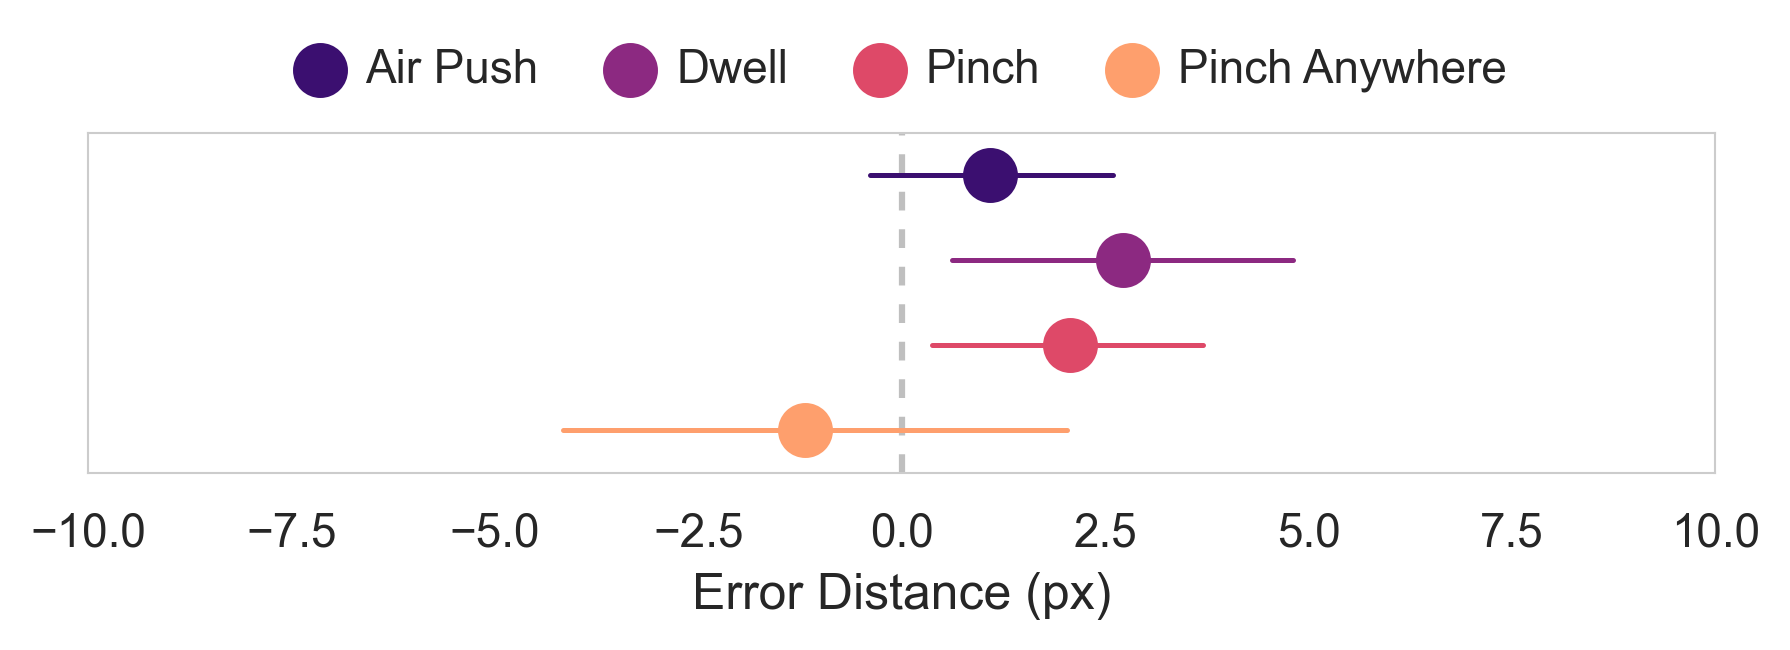

(<Figure size 2100x450 with 1 Axes>,
 <AxesSubplot:xlabel='Error Distance (px)'>)

In [708]:
point_plot(data_agg, "ErrorDistance", "Condition", len(data_agg.Condition.unique()), (-10, 10), "Error Distance (px)", v_annotate=0, plot_w=7, plot_h=1.5, show_all=False, filename="Plots/Error-Technique.pdf")

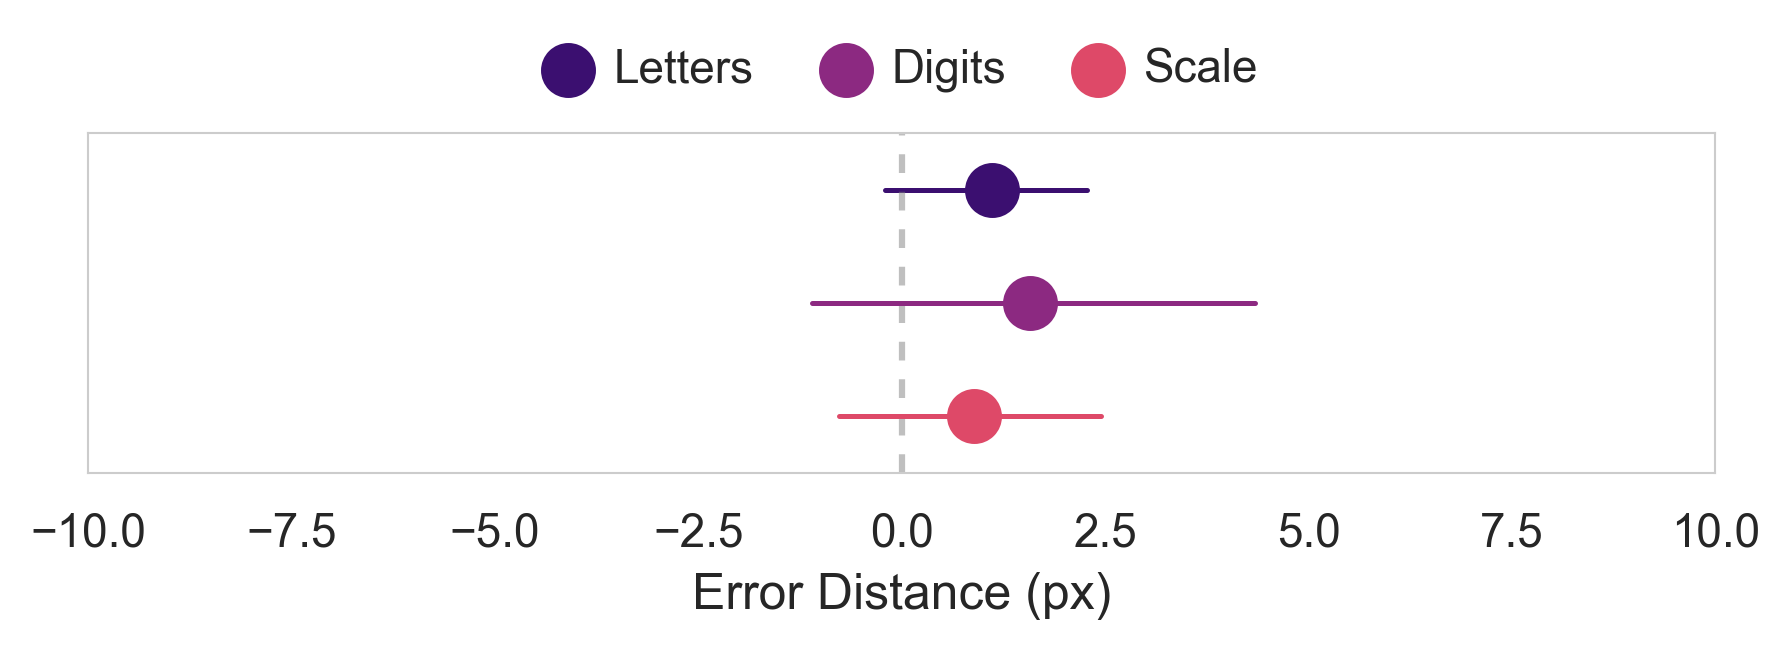

(<Figure size 2100x450 with 1 Axes>,
 <AxesSubplot:xlabel='Error Distance (px)'>)

In [682]:
point_plot(data_agg, "ErrorDistance", "Task", len(data_agg.Condition.unique()), (-10, 10), "Error Distance (px)", v_annotate=0, plot_w=7, plot_h=1.5, show_all=False, filename="Plots/Error-Task.pdf")

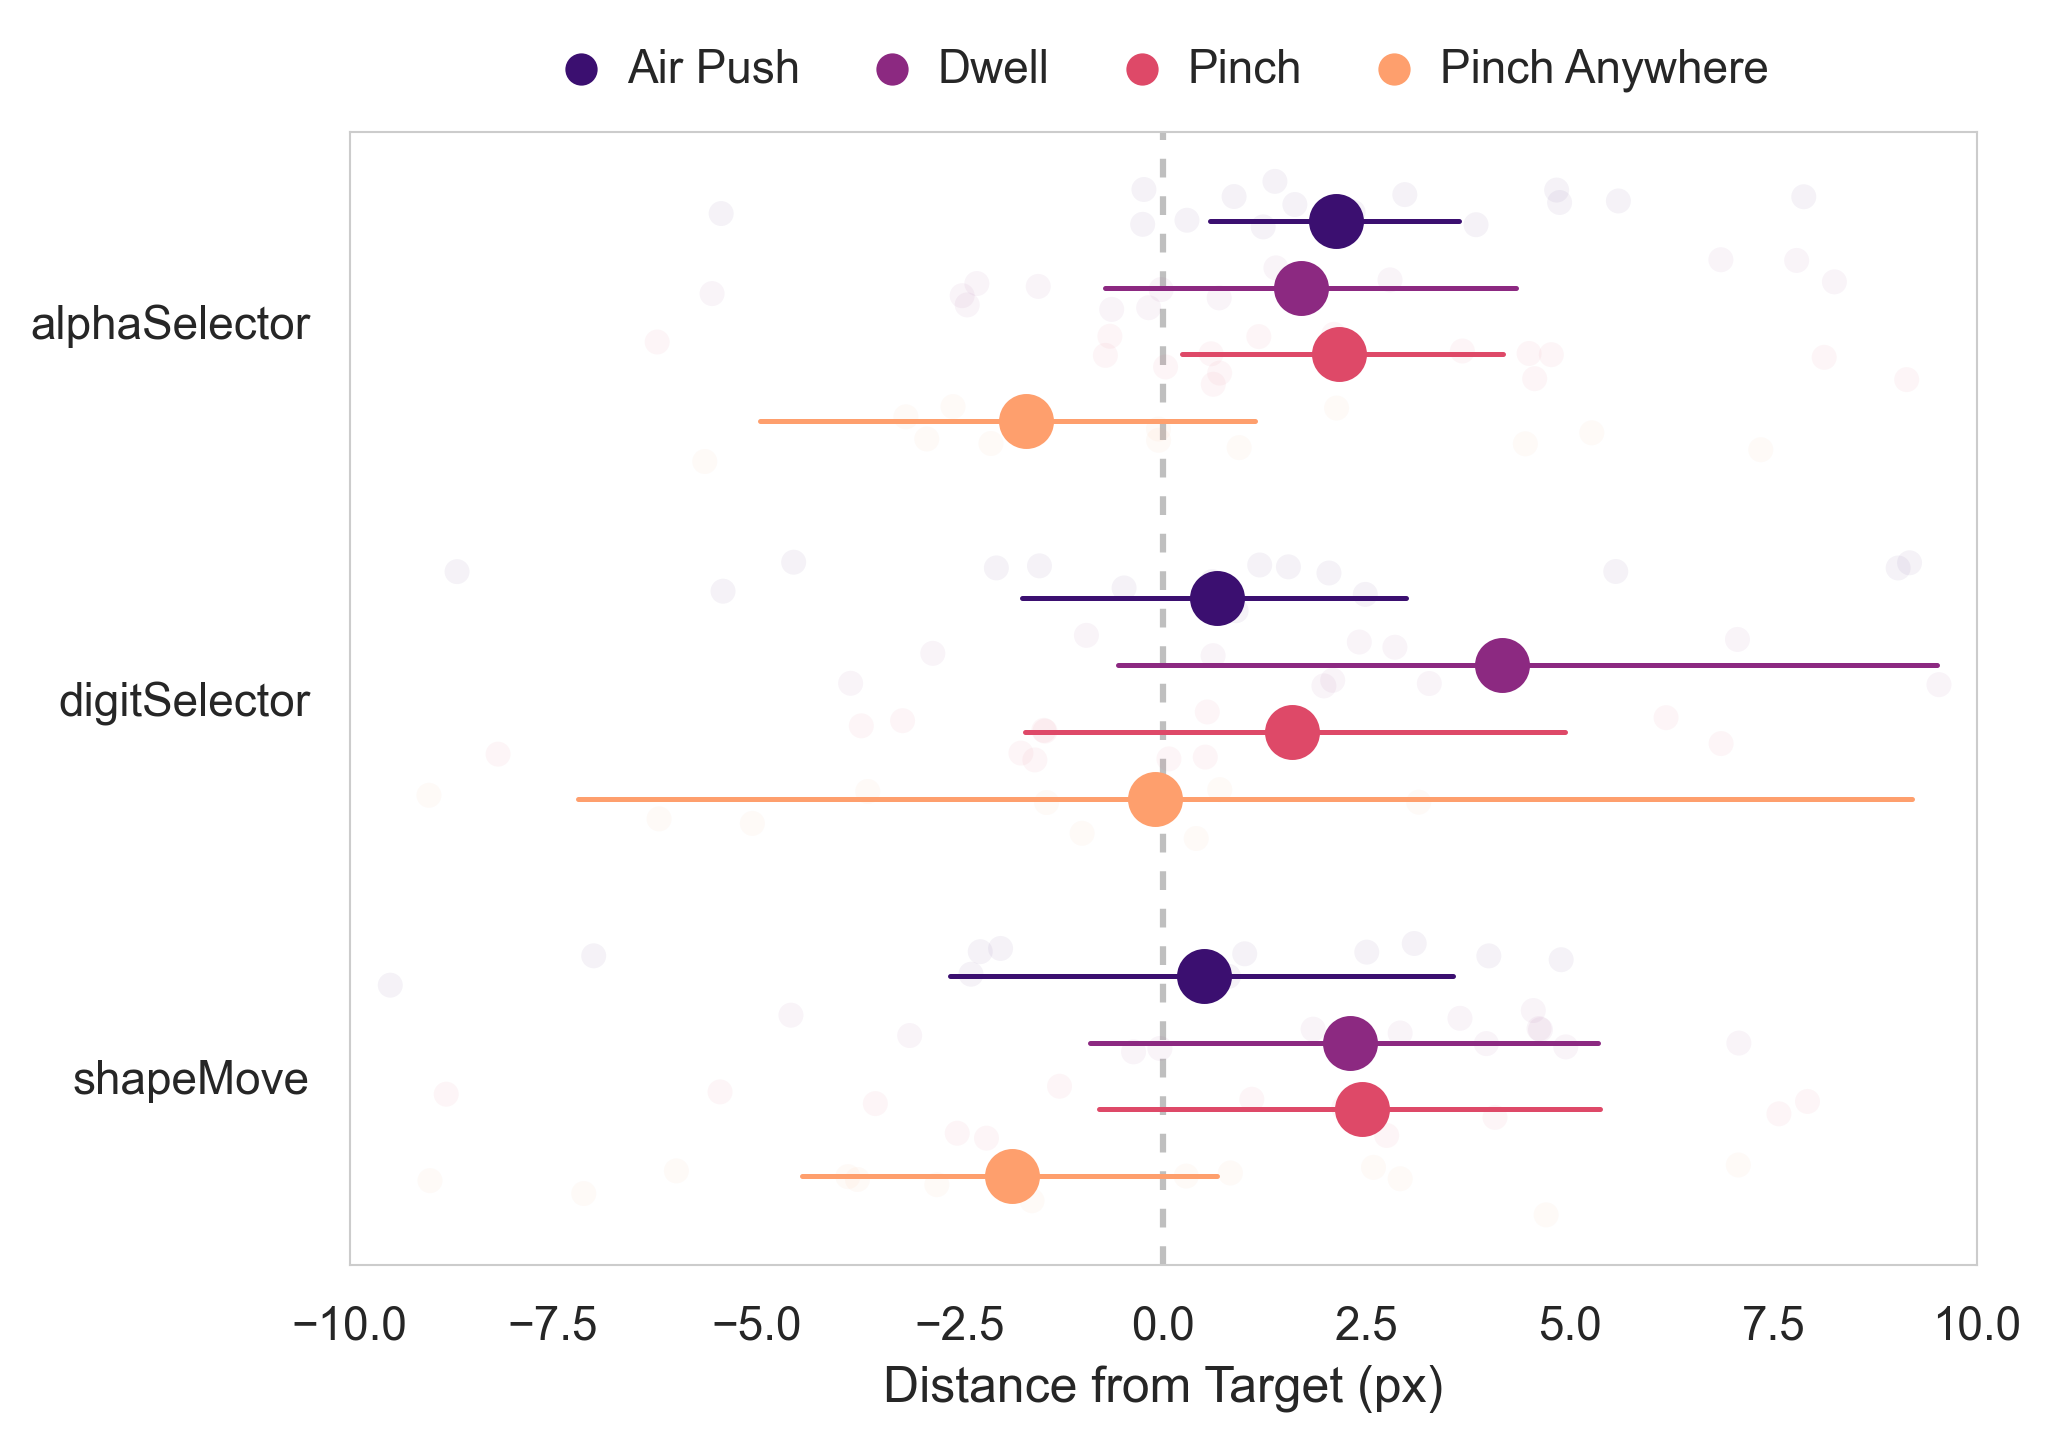

(<Figure size 2100x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Distance from Target (px)'>)

In [683]:
point_plot_2f(data_agg, "ErrorDistance", "Task", "Condition", n_iv1=len(data_agg.Condition.unique()), n_iv2=len(data_agg.Task.unique()), xlim=(-10, 10), xlab="Distance from Target (px)", v_annotate=0, show_grid=False)

## Cursor distance from target %

This measurement calculates final cursor position as a percentage of the target width - effectively normalising error distance to account for the varied target sizes.

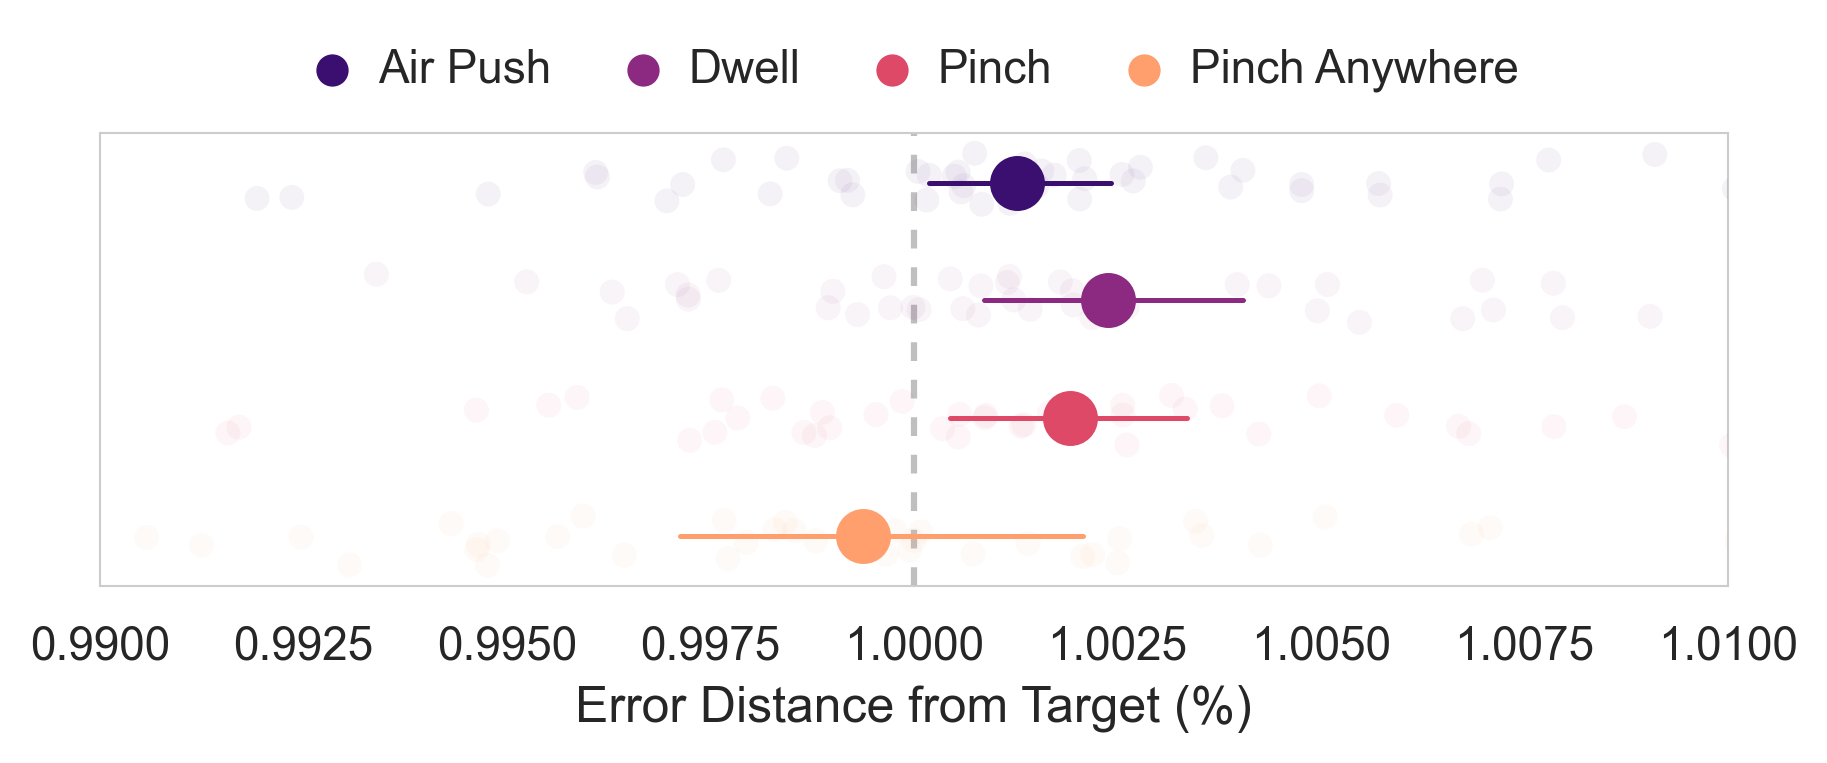

(<Figure size 2100x600 with 1 Axes>,
 <AxesSubplot:xlabel='Error Distance from Target (%)'>)

In [684]:
point_plot(data_agg, "ErrorDistanceRatio", "Condition", len(data_agg.Condition.unique()), (0.99, 1.01), "Error Distance from Target (%)", v_annotate=1.0, plot_w=7, plot_h=2, show_all=True)

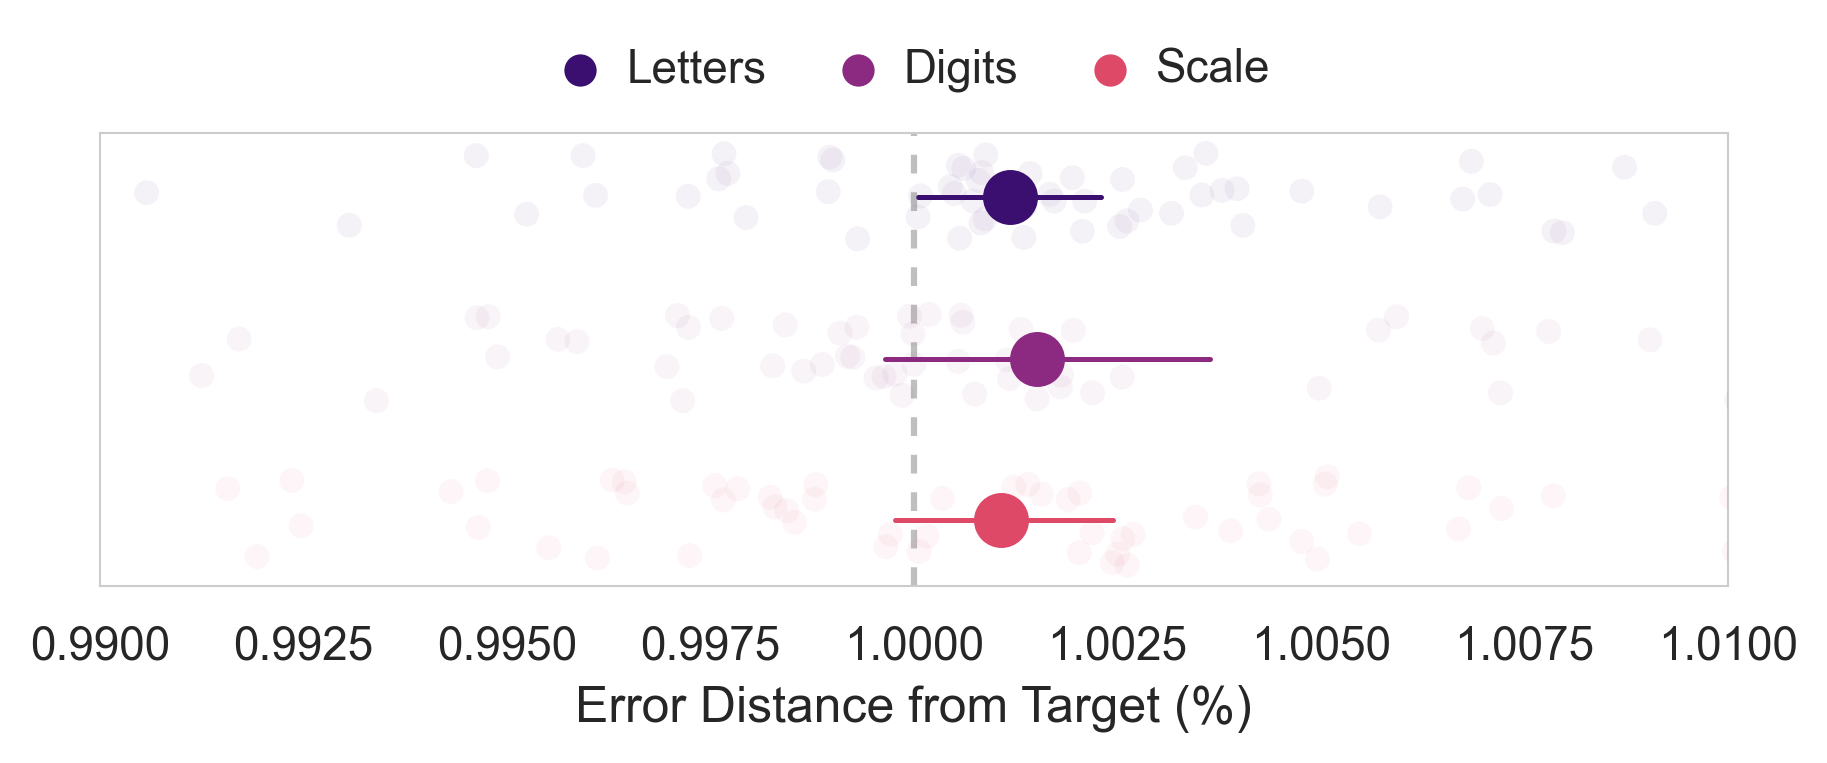

(<Figure size 2100x600 with 1 Axes>,
 <AxesSubplot:xlabel='Error Distance from Target (%)'>)

In [685]:
point_plot(data_agg, "ErrorDistanceRatio", "Task", len(data_agg.Task.unique()), (0.99, 1.01), "Error Distance from Target (%)", v_annotate=1.0, plot_w=7, plot_h=2, show_all=True)

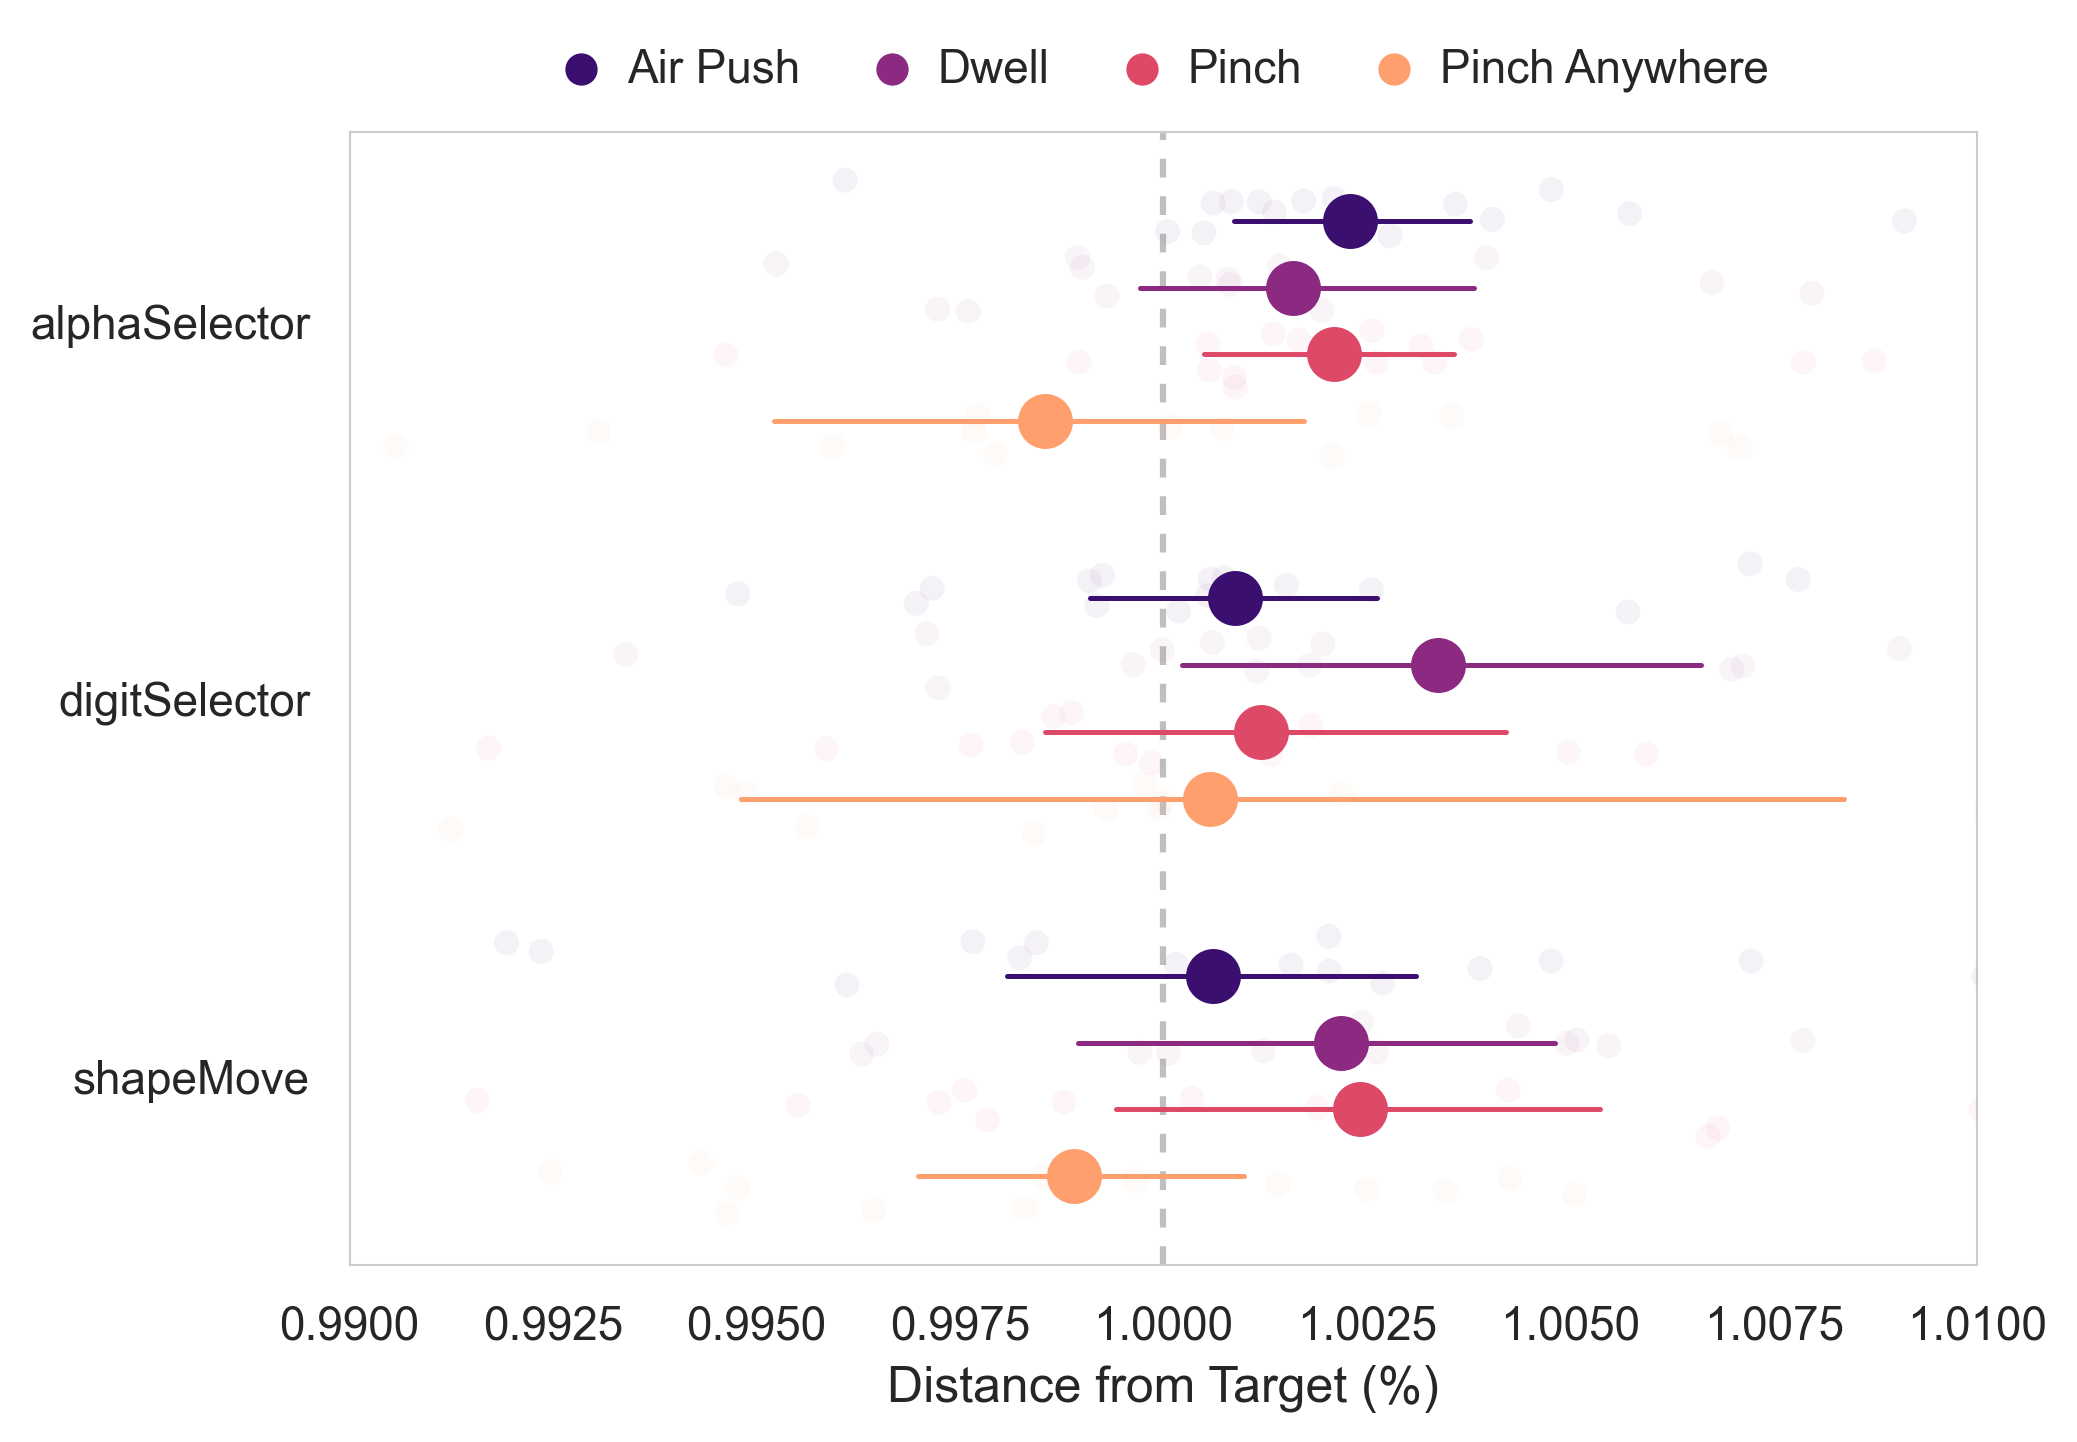

(<Figure size 2100x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Distance from Target (%)'>)

In [686]:
point_plot_2f(data_agg, "ErrorDistanceRatio", "Task", "Condition", n_iv1=len(data_agg.Condition.unique()), n_iv2=len(data_agg.Task.unique()), xlim=(0.99, 1.01), v_annotate=1.0, xlab="Distance from Target (%)", show_grid=False)

## Task Success

In [712]:
confidence(data_agg, "Success")

'Mean: 0.964594492136865, StDev: 0.08994517547116154, 95% confidence: [0.9513435330962055, 0.9778454511775245]'

In [711]:
data_agg.groupby('Condition', as_index=False)['Success'].mean()

,Condition,Success
0,baseline,0.989912
1,Dwell,0.962785
2,pinchOnCircle,0.967929
3,pinchAny,0.936581


In [717]:
data_agg.groupby(['Condition'], as_index=False)['Success'].mean()

,Condition,Success
0,baseline,0.989912
1,Dwell,0.962785
2,pinchOnCircle,0.967929
3,pinchAny,0.936581


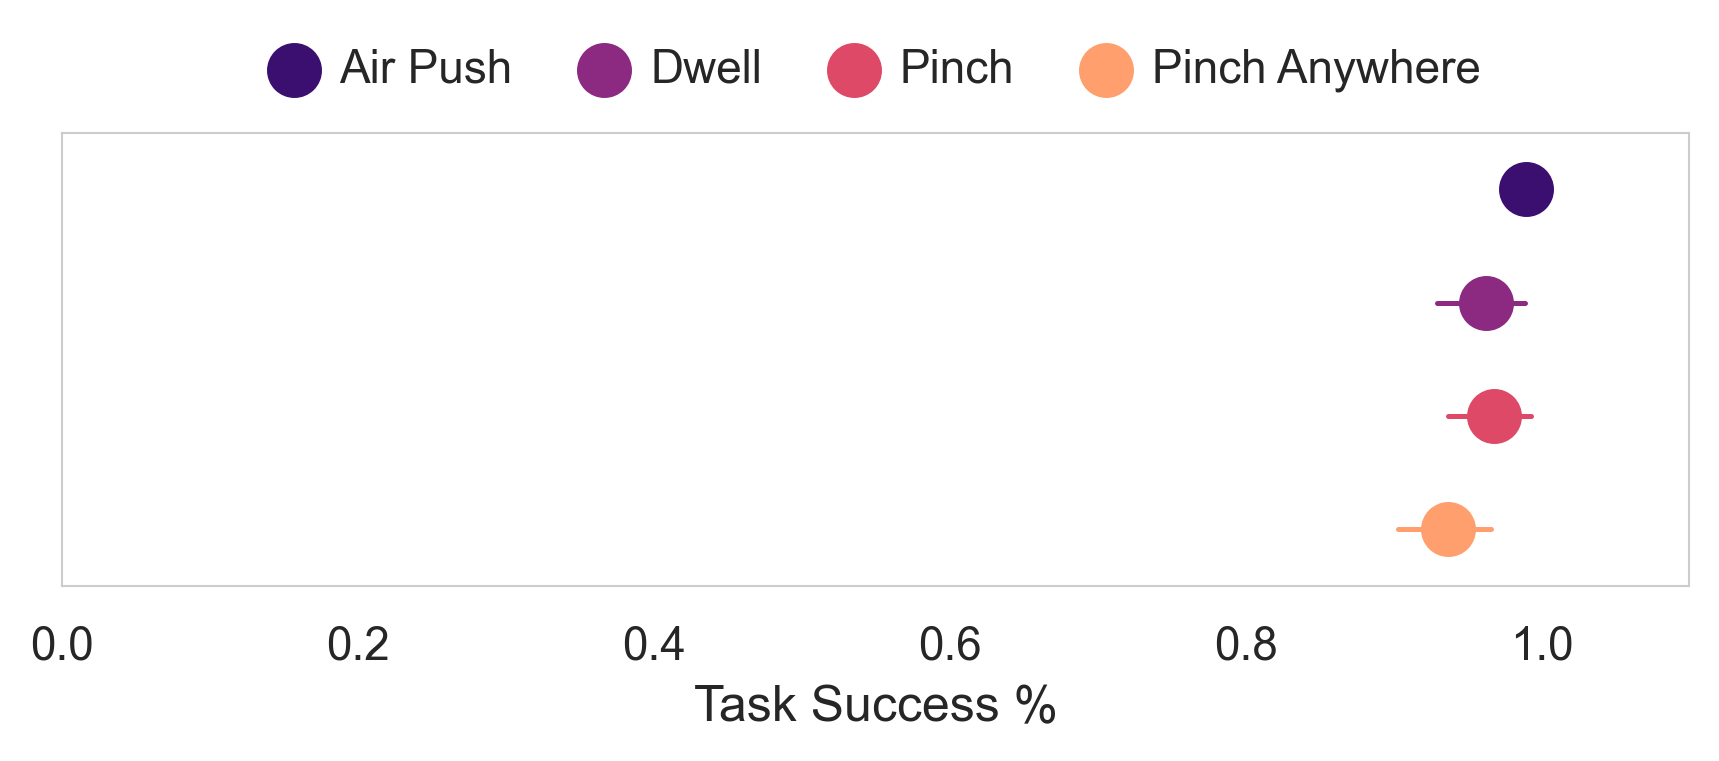

(<Figure size 2100x600 with 1 Axes>, <AxesSubplot:xlabel='Task Success %'>)

In [687]:
point_plot(data_agg, "Success", "Condition", len(data_agg.Condition.unique()), (0, 1.1), "Task Success %", plot_w=7, plot_h=2, show_all=False)

## Number of target overshoots

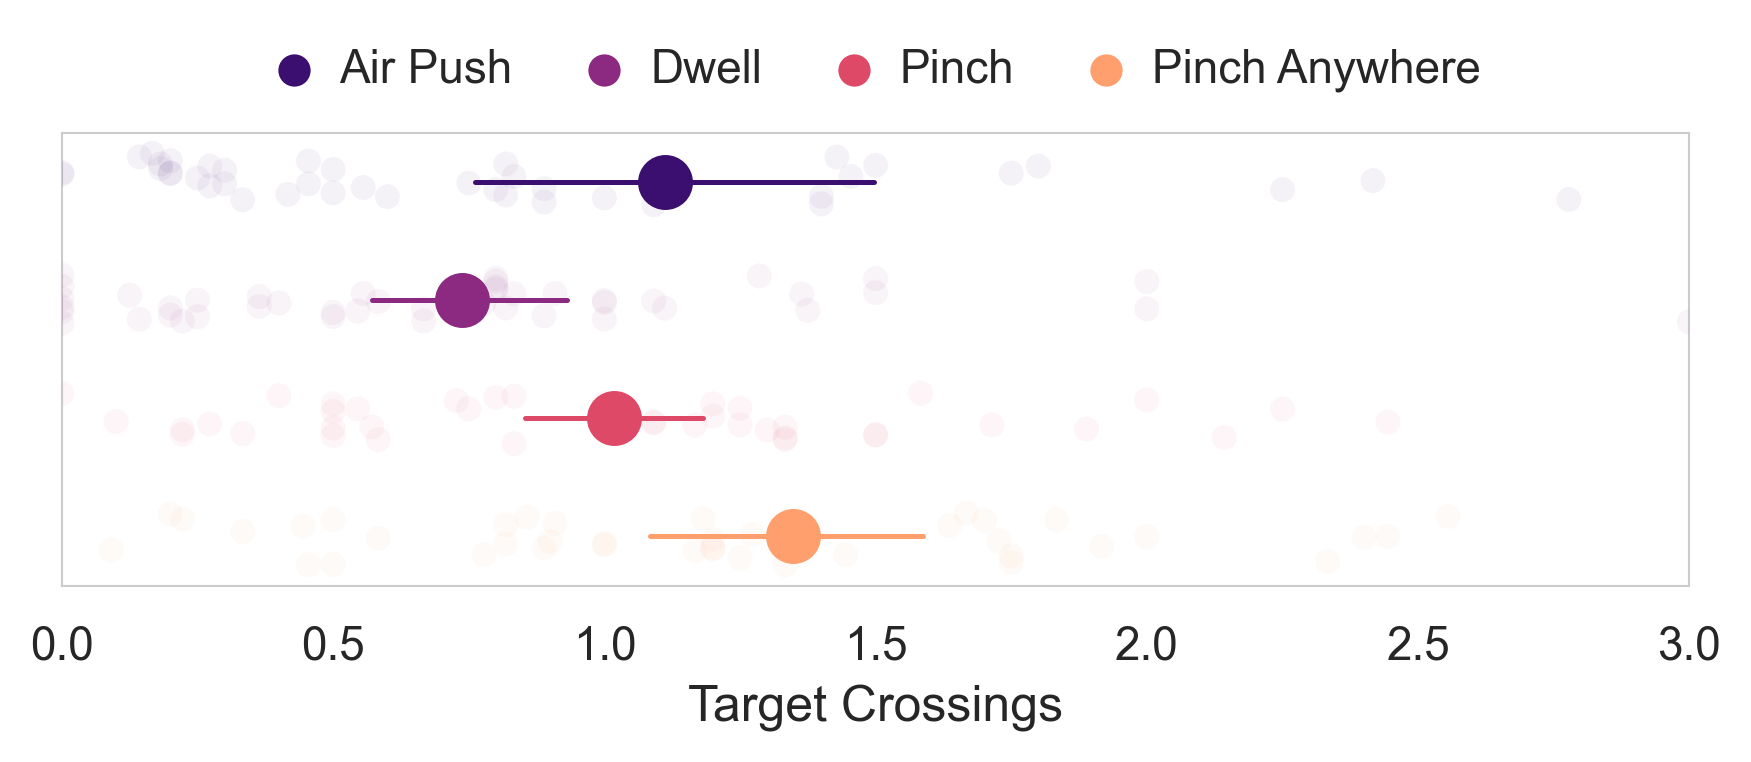

(<Figure size 2100x600 with 1 Axes>, <AxesSubplot:xlabel='Target Crossings'>)

In [688]:
point_plot(data_agg, "Overshoots", "Condition", len(data_agg.Condition.unique()), (0, 3), "Target Crossings", plot_w=7, plot_h=2, show_all=True)

## Number of cursor activations

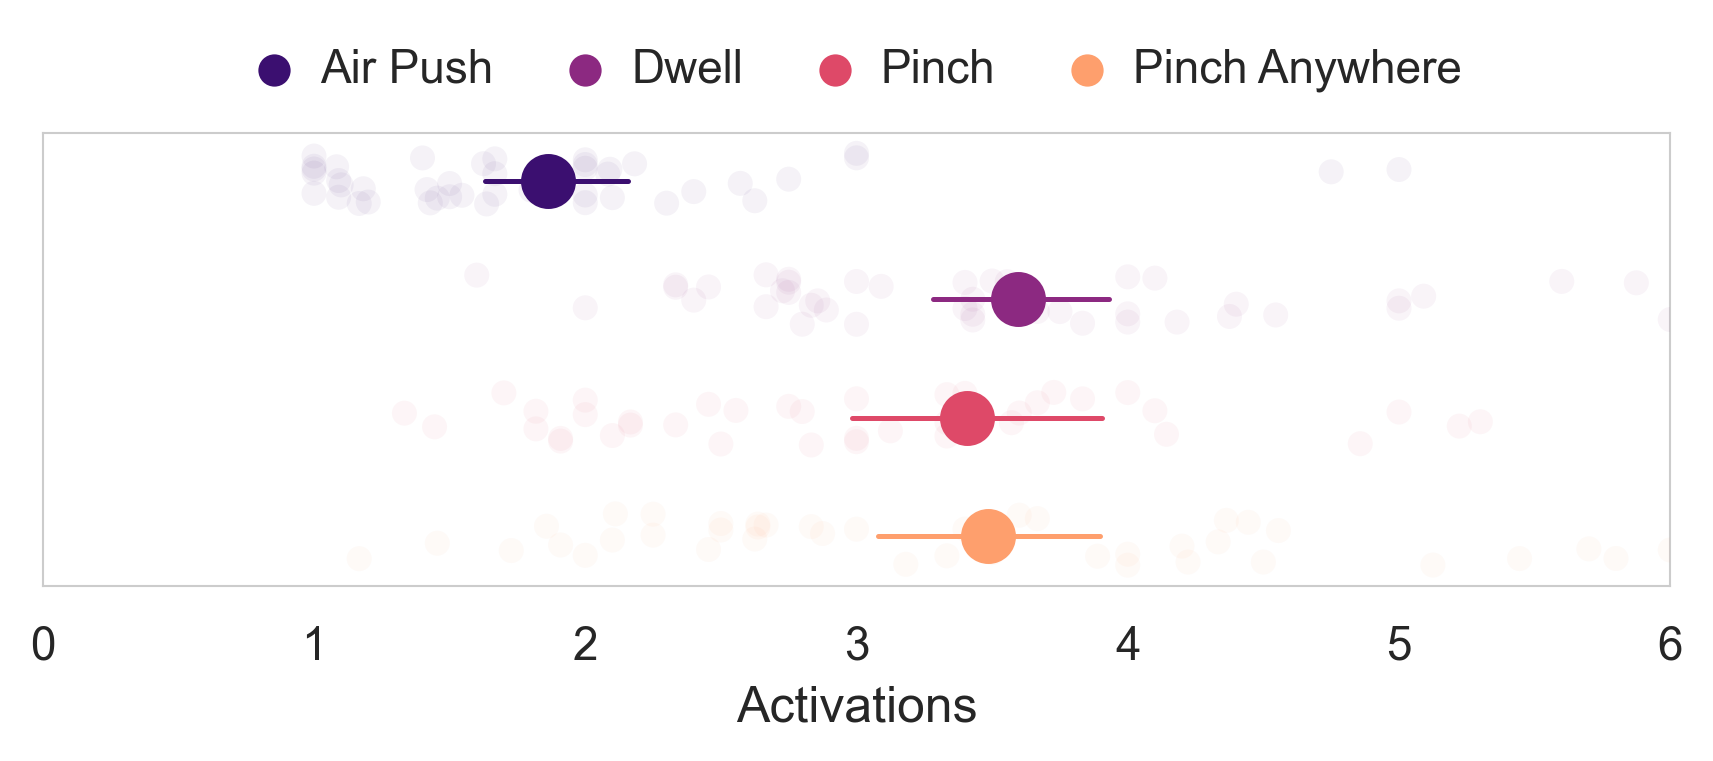

(<Figure size 2100x600 with 1 Axes>, <AxesSubplot:xlabel='Activations'>)

In [689]:
point_plot(data_agg, "Activations", "Condition", len(data_agg.Condition.unique()), (0, 6), "Activations", plot_w=7, plot_h=2, show_all=True)

# Analysis

## Task time

In [690]:
s_w = stats.shapiro(data_agg["Time"])

if s_w.pvalue <= 0.05:
    print("Task time data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Time", kind="kde")
else:
    aov_time = pg.rm_anova(dv='Time', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_time)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_time = pg.pairwise_ttests(dv='Time', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_time)


ANOVA SUMMARY

Source                       SS    ddof1    ddof2             MS       F    p-unc    p-GG-corr    np2    eps
----------------  -------------  -------  -------  -------------  ------  -------  -----------  -----  -----
Condition          75999167.338        3       39   25333055.779   4.218    0.011        0.015  0.245  0.879
Task              276796132.236        2       26  138398066.118  16.235    0.000        0.000  0.555  0.634
Condition * Task   12614577.340        6       78    2102429.557   0.577    0.748        0.604  0.042  0.415

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T     dof  alternative      p-unc     BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  ------  -------------  -------  -------  -------
Condition         -              Dwell          baseline       True

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


## Time to target

In [691]:
df_hits = data_agg[data_agg['Time to Target'] != -1]

s_w = stats.shapiro(data_agg["Time to Target"])

if s_w.pvalue <= 0.05:
    print("Time to target data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Time to Target", kind="kde")
else:
    aov_ttt = pg.rm_anova(dv='Time to Target', within=['Condition', 'Task'], subject='P', data=df_hits)
    pg.print_table(aov_ttt)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_ttt = pg.pairwise_ttests(dv='Time to Target', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=df_hits)
    pg.print_table(ph_ttt)

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "



ANOVA SUMMARY

Source                      SS    ddof1    ddof2            MS       F    p-unc    p-GG-corr    np2    eps
----------------  ------------  -------  -------  ------------  ------  -------  -----------  -----  -----
Condition         79326503.244        3       39  26442167.748  22.048    0.000        0.000  0.629  0.947
Task              28873026.644        2       26  14436513.322  16.594    0.000        0.000  0.561  0.640
Condition * Task   4524151.083        6       78    754025.180   0.931    0.478        0.437  0.067  0.516

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T     dof  alternative      p-unc       BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  ------  -------------  -------  ---------  -------
Condition         -              Dwell          baseline       True      

In [692]:
confidence(data_agg, "Time to Target")

'Mean: 4659.163052807869, StDev: 1487.8299551940336, 95% confidence: [4439.972043479485, 4878.354062136252]'

## Time grabbed

In [700]:
s_w = stats.shapiro(data_agg["Time Grabbed"])

if s_w.pvalue <= 0.05:
    print("Task time data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Time Grabbed", kind="kde")
else:
    aov_time = pg.rm_anova(dv='Time Grabbed', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_time)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_time = pg.pairwise_ttests(dv='Time Grabbed', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_time)


ANOVA SUMMARY

Source                      SS    ddof1    ddof2            MS       F    p-unc    p-GG-corr    np2    eps
----------------  ------------  -------  -------  ------------  ------  -------  -----------  -----  -----
Condition         37757574.929        3       39  12585858.310  53.816    0.000        0.000  0.805  0.953
Task                678008.037        2       26    339004.019   1.174    0.325        0.316  0.083  0.758
Condition * Task   3099669.325        6       78    516611.554   1.737    0.123        0.176  0.118  0.497

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T     dof  alternative      p-unc         BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  ------  -------------  -------  -----------  -------
Condition         -              Dwell          baseline       True  

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


## Error distance

In [710]:
s_w = stats.shapiro(data_agg["ErrorDistance"])

if s_w.pvalue <= 0.05:
    print("Error distance data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="ErrorDistance", kind="kde")
else:
    aov_ed = pg.rm_anova(dv='ErrorDistance', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_ed)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_ed = pg.pairwise_ttests(dv='ErrorDistance', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_ed)


ANOVA SUMMARY

Source                 SS    ddof1    ddof2       MS      F    p-unc    p-GG-corr    np2    eps
----------------  -------  -------  -------  -------  -----  -------  -----------  -----  -----
Condition         436.220        3       39  145.407  2.743    0.056        0.083  0.174  0.665
Task               19.255        2       26    9.628  0.114    0.893        0.858  0.009  0.830
Condition * Task   97.620        6       78   16.270  0.367    0.898        0.718  0.027  0.370

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T     dof  alternative      p-unc    BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  ------  -------------  -------  ------  -------
Condition         -              Dwell          baseline       True      True           1.529  13.000  two-sided        0.150   0.698 

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


In [695]:
confidence(data_agg, "ErrorDistance")

'Mean: 1.1934720419589806, StDev: 7.477368703161277, 95% confidence: [0.09188648277278855, 2.2950576011451727]'

## Task success rate

In [696]:
s_w = stats.shapiro(data_agg["Success"])

if s_w.pvalue <= 0.05:
    print("Task success rate data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Success", kind="kde")
else:
    aov_success = pg.rm_anova(dv='Success', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_success)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_success = pg.pairwise_ttests(dv='Success', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_success)

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "



ANOVA SUMMARY

Source               SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
----------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
Condition         0.062        3       39  0.021  3.947    0.015        0.019  0.233  0.893
Task              0.067        2       26  0.033  2.218    0.129        0.148  0.146  0.695
Condition * Task  0.015        6       78  0.003  0.386    0.886        0.691  0.029  0.347

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T     dof  alternative      p-unc    BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  ------  -------------  -------  ------  -------
Condition         -              Dwell          baseline       True      True          -1.982  13.000  two-sided        0.069   1.232   -0.679
Condition  

In [697]:
confidence(data_agg, "Success")

'Mean: 0.964594492136865, StDev: 0.08994517547116154, 95% confidence: [0.9513435330962055, 0.9778454511775245]'

# Extra Plots

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


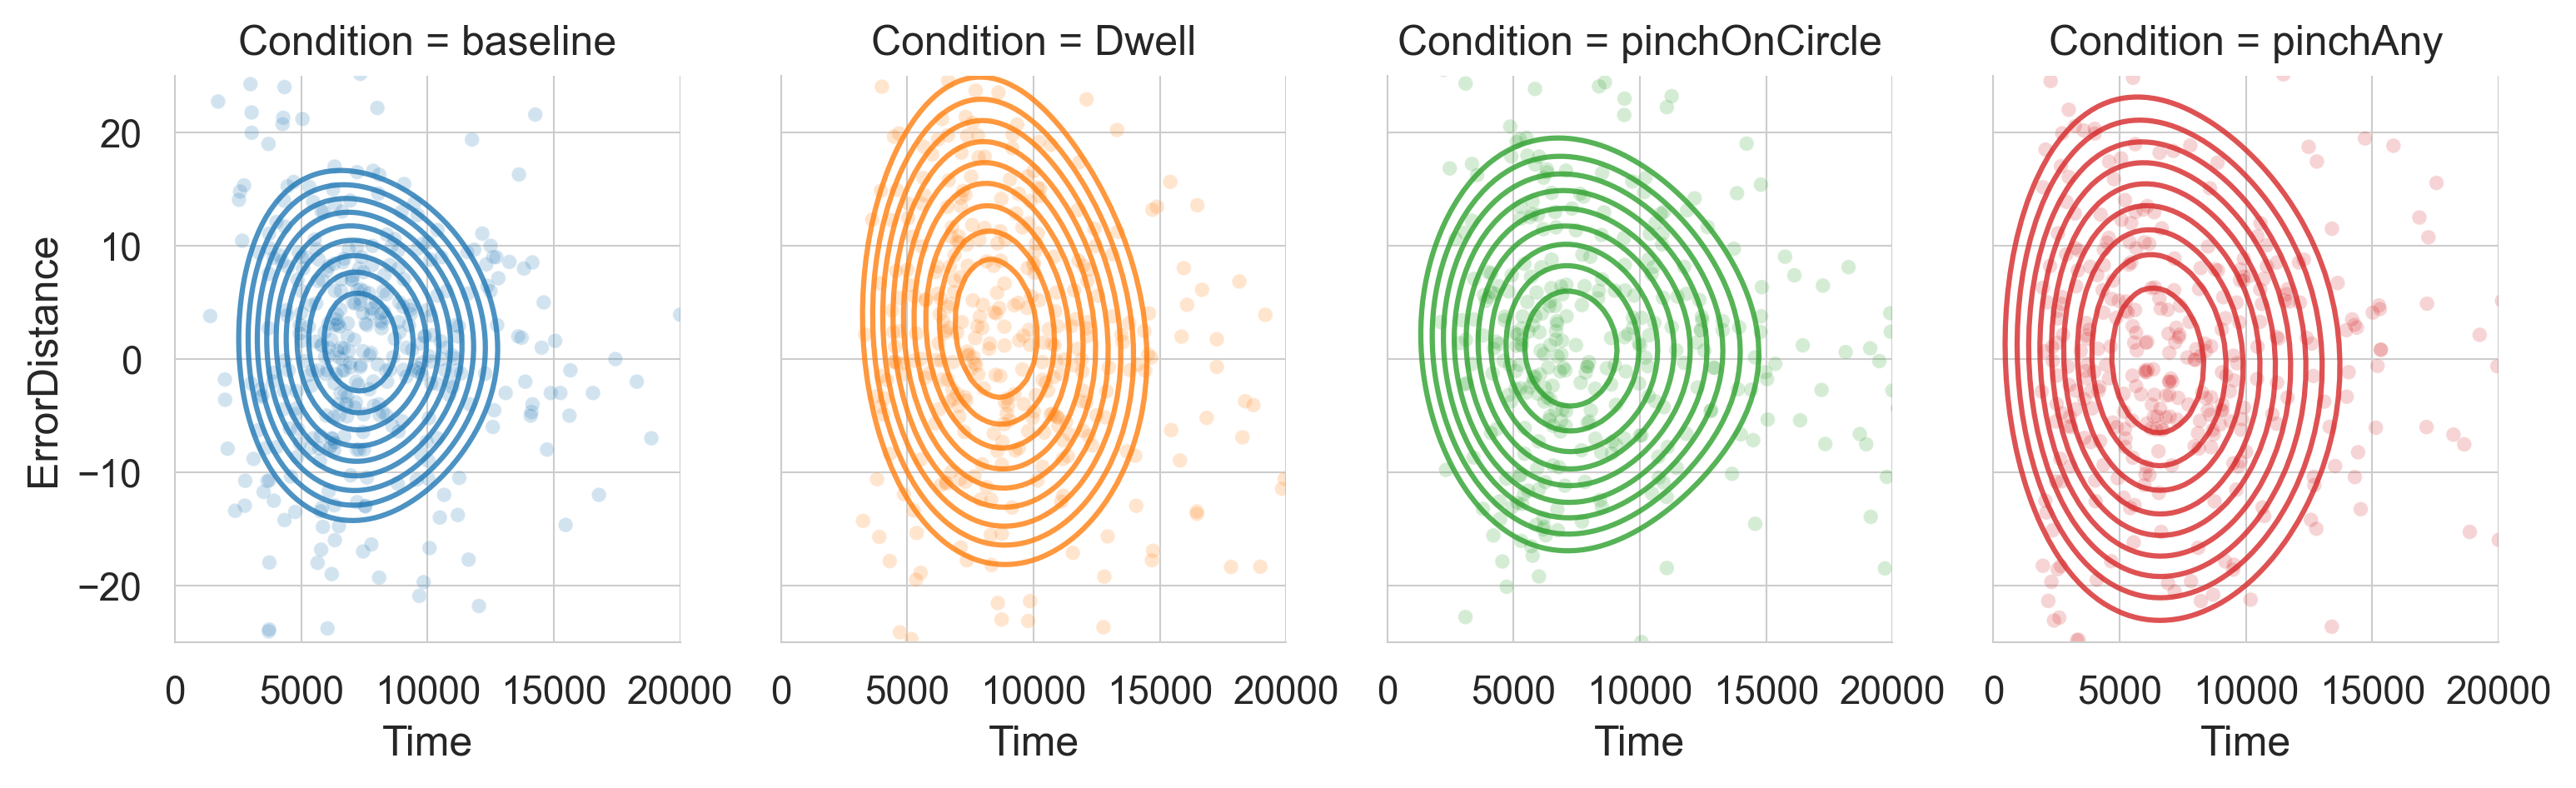

In [698]:
g = sns.FacetGrid(data_filtered, col="Condition", hue="Condition", gridspec_kws={"wspace":0.2})
g.map(sns.kdeplot, "Time", "ErrorDistance", shade=False, alpha=0.8, bw_adjust=2, thresh=0.5)
g.map(sns.scatterplot, "Time", "ErrorDistance", alpha=0.2, size=0.5)
g.set(xlim=(0, 20000), ylim=(-25, 25))